In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from sipm.sipm import gauss, compound_poisson
from scipy.optimize import curve_fit
from scipy.special import erf, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
import ROOT

Welcome to JupyROOT 6.26/06


In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

In [4]:
!pwd

/home/as111/sipm-analysis


# Top tile calibration (1122 data)

## Load data

In [5]:
bias = [63, 65, 67, 69, 71]
ds1122top = []
for i,volt in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    file = ROOT.TFile("root/calibration_1122_{}V_top.root".format(volt), "read")
    tree = file.Get("tree")
    nev = 0
    for iev,ev in enumerate(tree):
        nev += 1
        for ich,ch in enumerate(dset.ch):
            ch.baseline_avg.append(ev.bsl_avg[ich])
            ch.baseline_med.append(ev.bsl_med[ich])
            ch.baseline_std.append(ev.bsl_std[ich])
            ch.acquisition_max.append(ev.acq_max[ich])
            ch.acquisition_min.append(ev.acq_min[ich])
            ch.famp.append(ev.fil_amp[ich])
            ch.integral_long.append(ev.int_long[ich])
    file.Close()
    print('Top {}V {} events loaded'.format(volt, nev))
    for ch in dset.ch:
        ch.cumulative_nevents = nev
    ds1122top.append(dset)

Top 63V 219823 events loaded
Top 65V 219816 events loaded
Top 67V 219803 events loaded
Top 69V 219813 events loaded
Top 71V 219812 events loaded


## Plot filtered amplitude histogram and analyze
Here we look at the prompt amplitude of AR-filtered waveforms ($A_{\rm filt}$).<br>
The PE peaks in the histograms are fitted with Gaussian $(N_k, A_k, \sigma_k)$, where $k$ is PE count.<br>
$(k, A_k)$ is fitted with linear function $A_k = Q_A \times k  + b$.<br>
$(V, Q_A)$ is then fitted with linear function for breakdown voltage $Q_A = C(V-V_{bd})$.<br>
$(k, N_k)$ is fitted with Vinogradov model (Compound Poisson) where $\mu$ is laser intensity and $p$ is DiCT probability.<br>

A1=71.988 sigma1=8.059
A1=88.724 sigma1=8.607
A1=110.405 sigma1=9.928
A1=131.502 sigma1=10.412
A1=143.694 sigma1=11.407
Channel 0 Vbd=55.369+/-0.196V slope=9.969+/-0.158
A1=77.790 sigma1=8.261
A1=91.817 sigma1=8.395
A1=112.067 sigma1=9.454
A1=133.516 sigma1=9.679
A1=147.613 sigma1=10.395
Channel 1 Vbd=55.502+/-0.207V slope=10.154+/-0.158
A1=66.843 sigma1=8.245
A1=84.745 sigma1=8.642
A1=98.409 sigma1=9.367
A1=114.356 sigma1=10.327
A1=133.060 sigma1=11.559
Channel 2 Vbd=55.651+/-0.168V slope=9.208+/-0.129
A1=62.058 sigma1=7.742
A1=78.610 sigma1=8.080
A1=93.677 sigma1=8.463
A1=108.332 sigma1=9.026
A1=121.897 sigma1=10.136
Channel 3 Vbd=55.010+/-0.136V slope=8.161+/-0.098


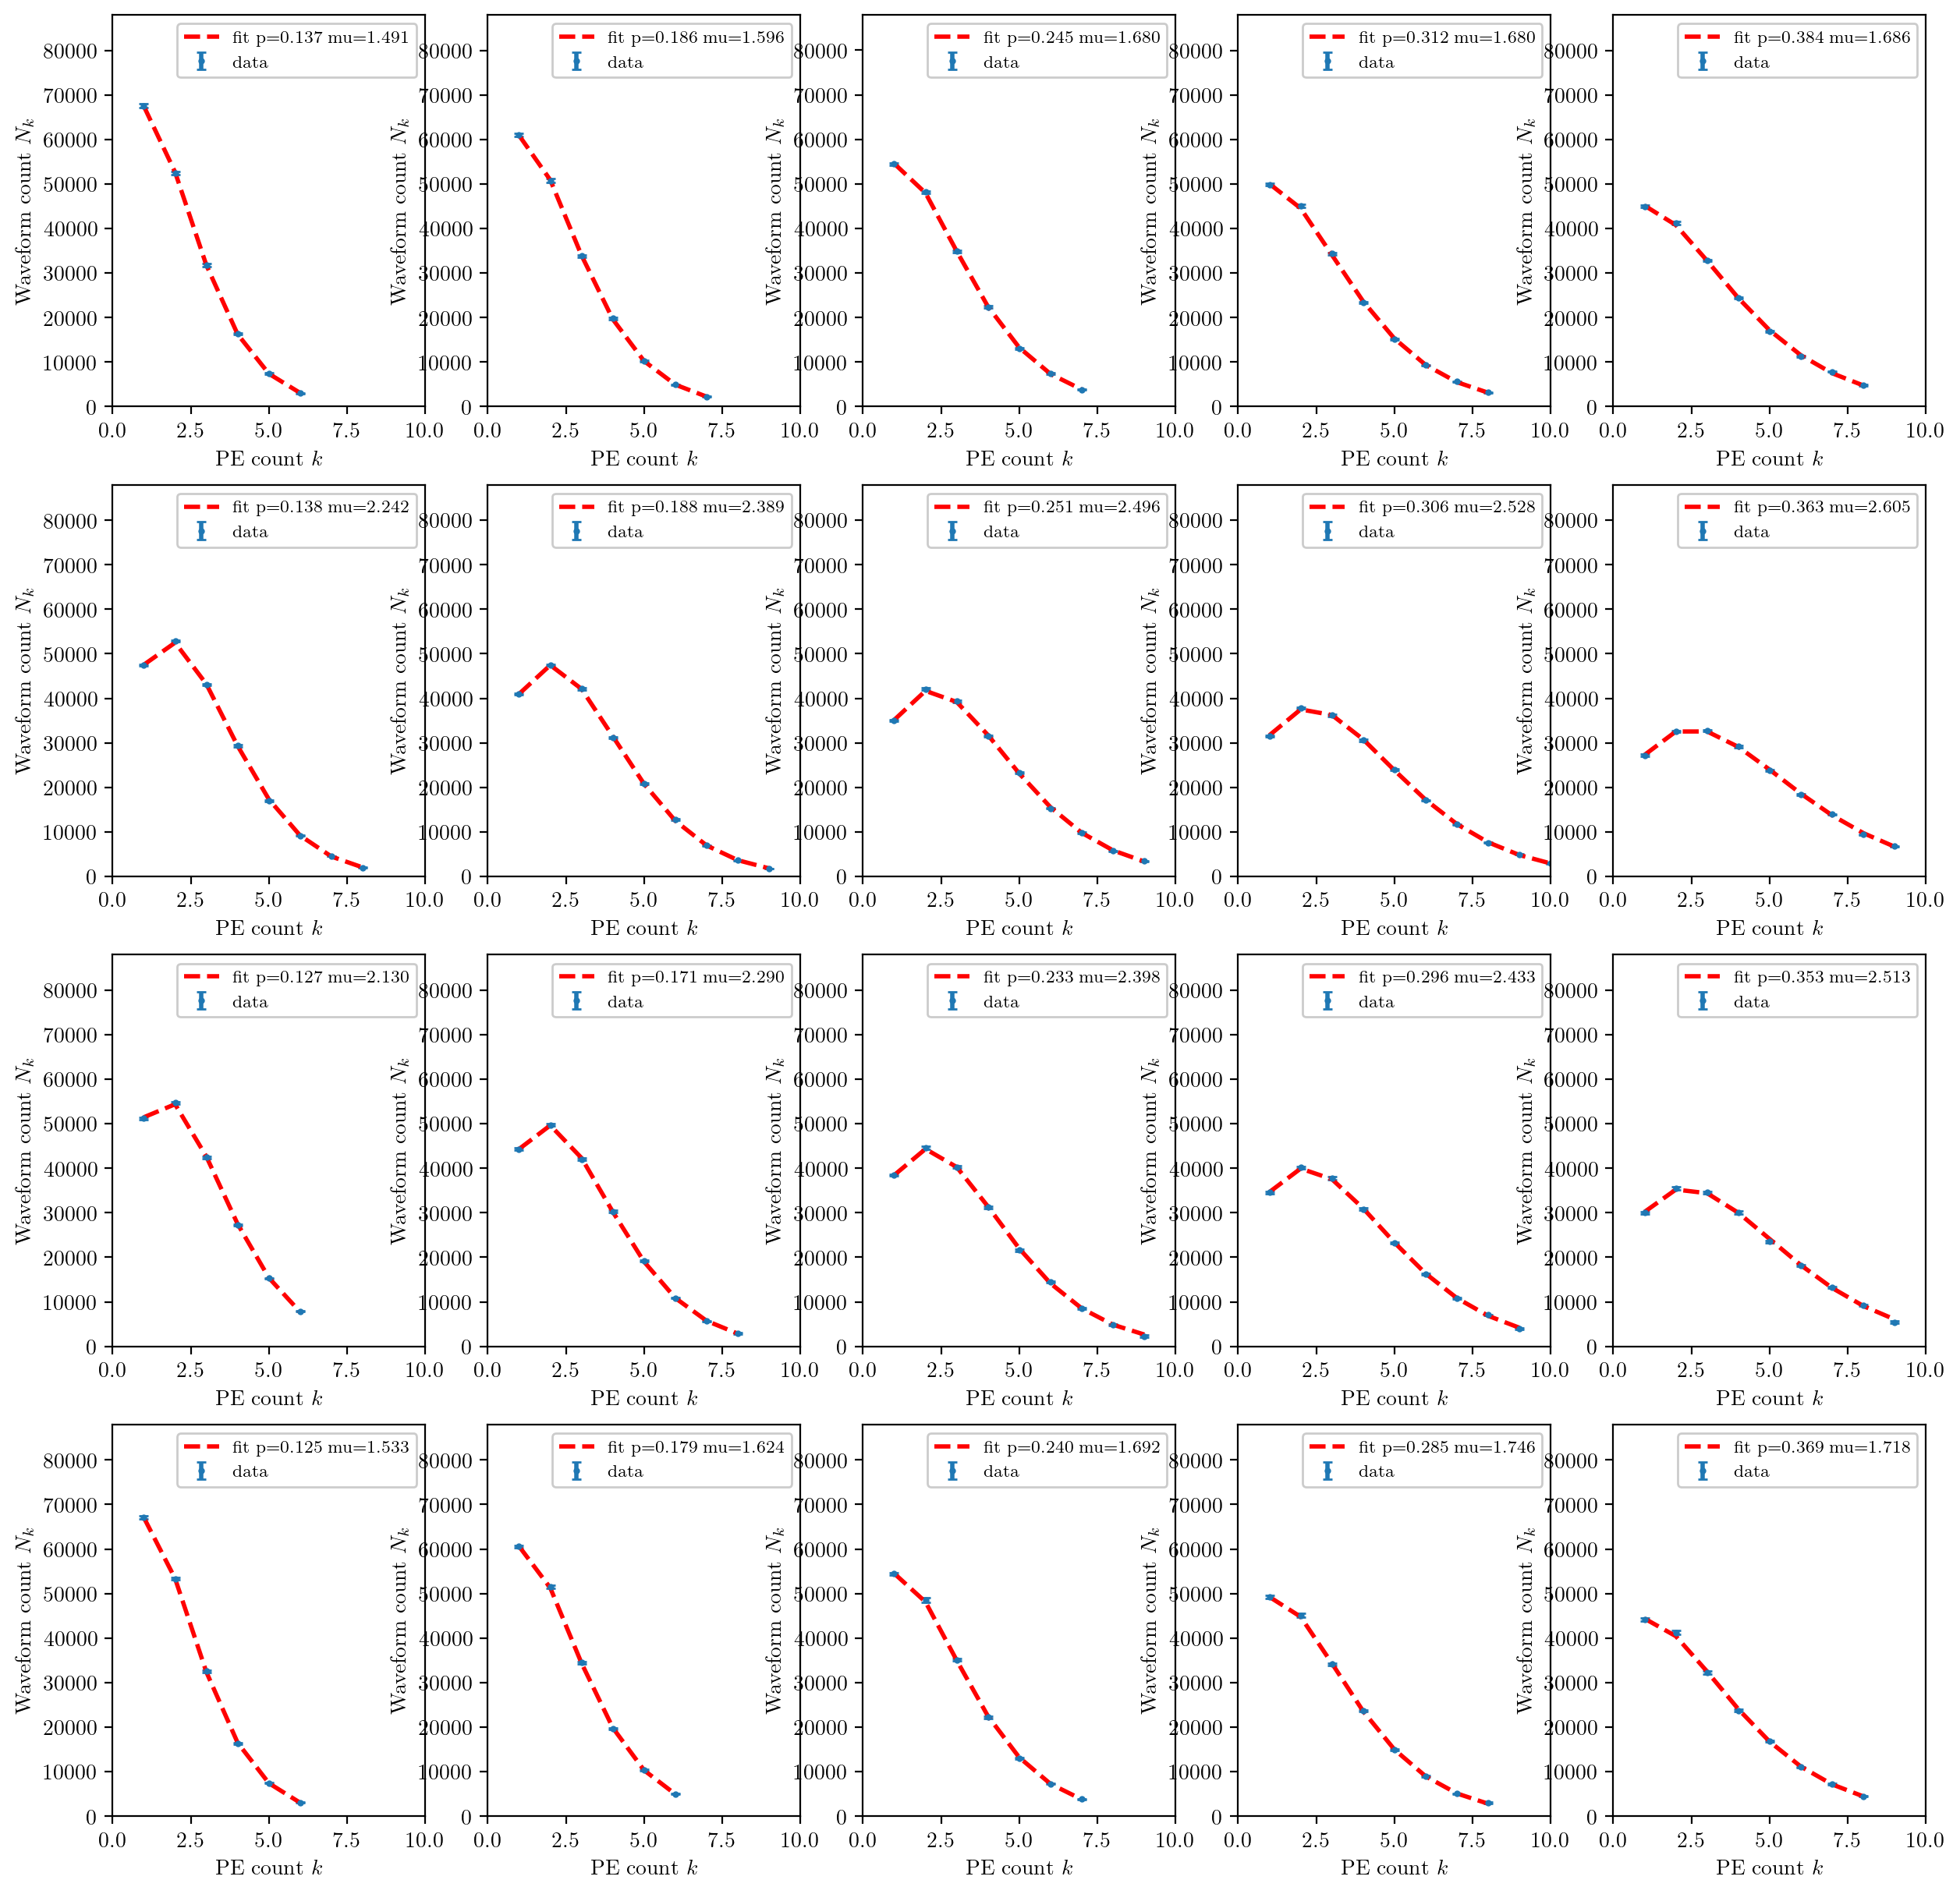

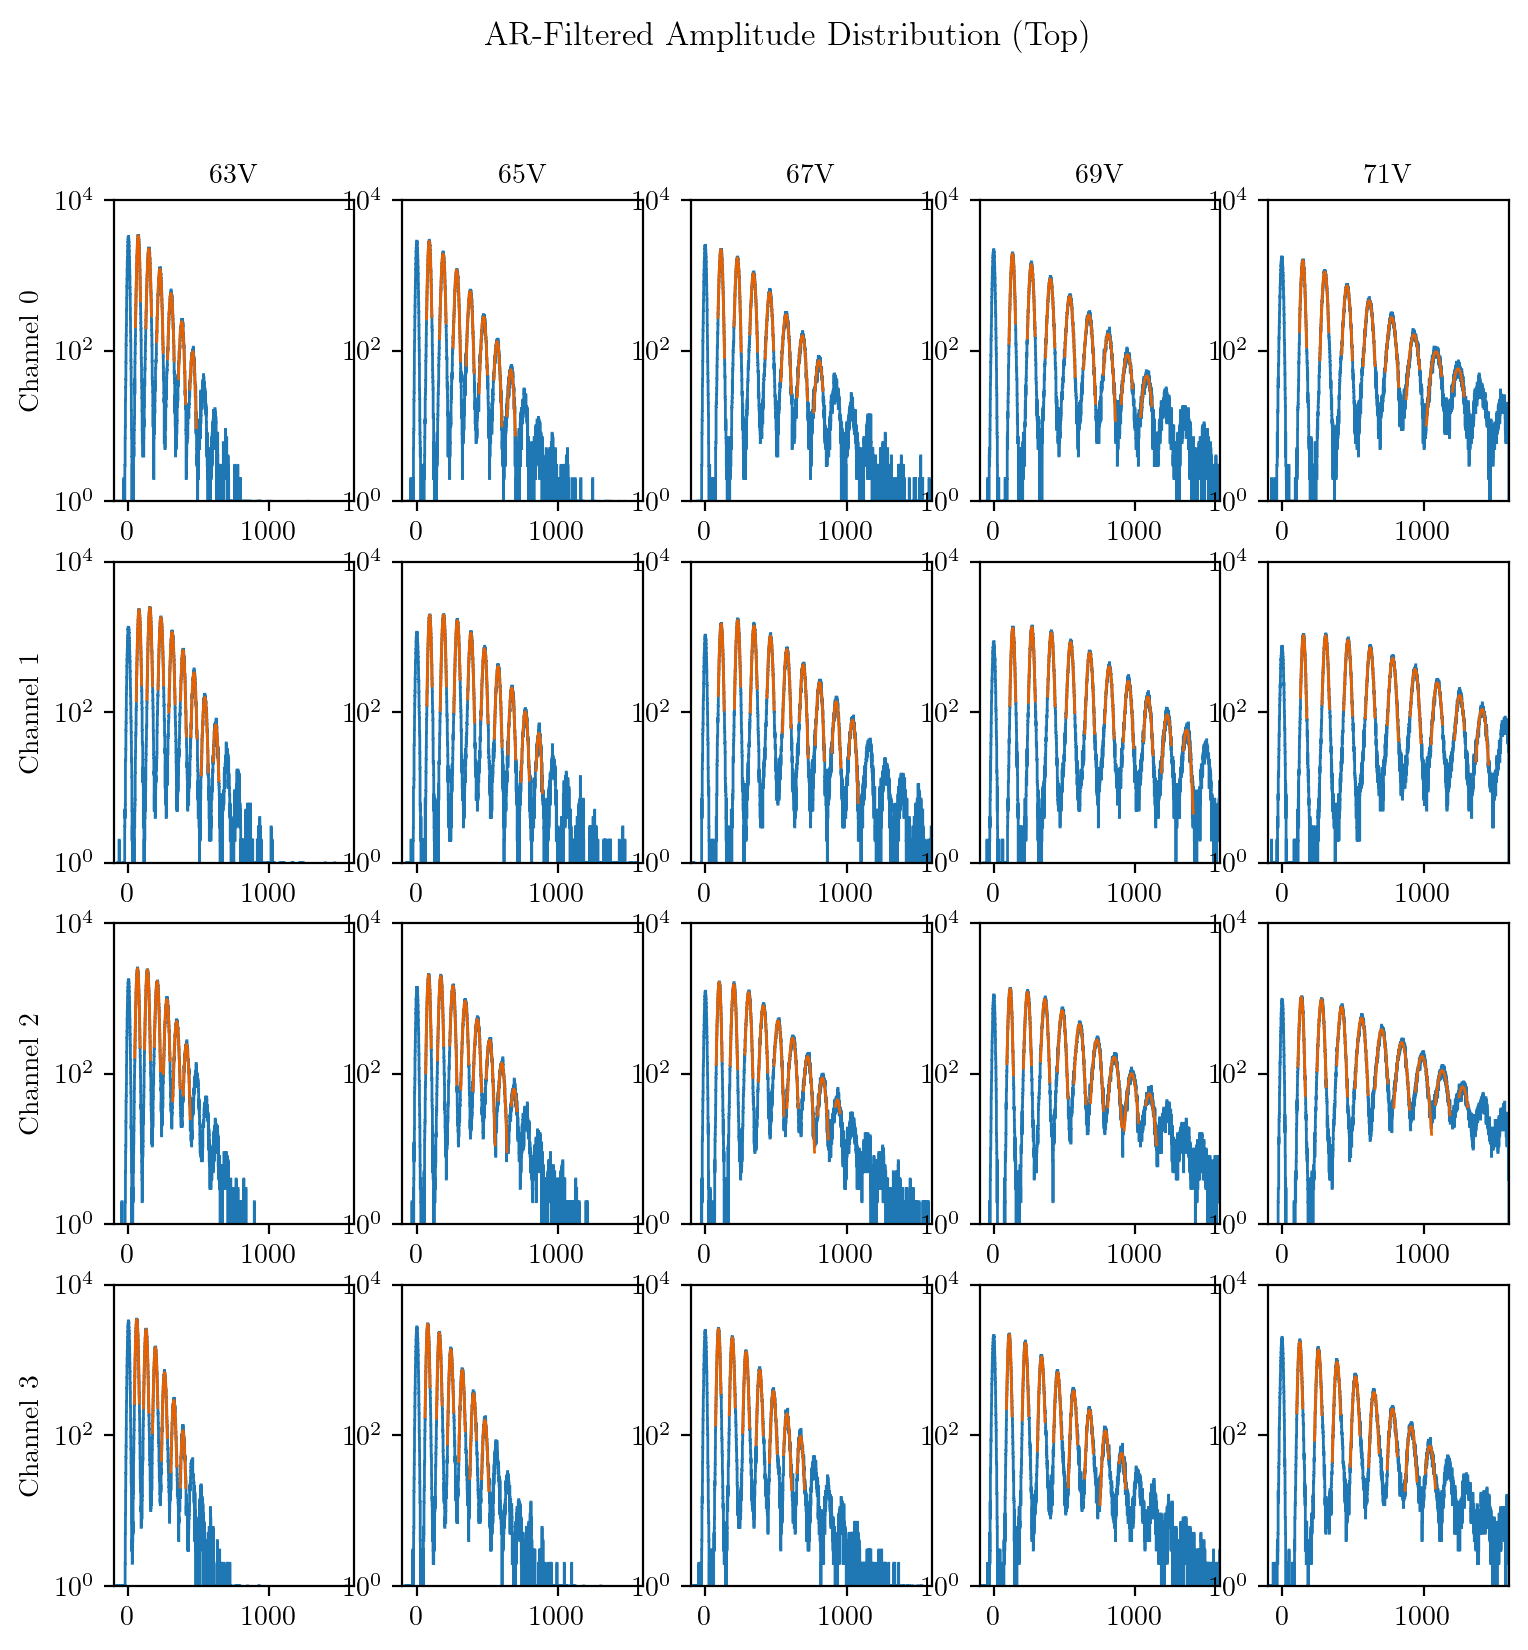

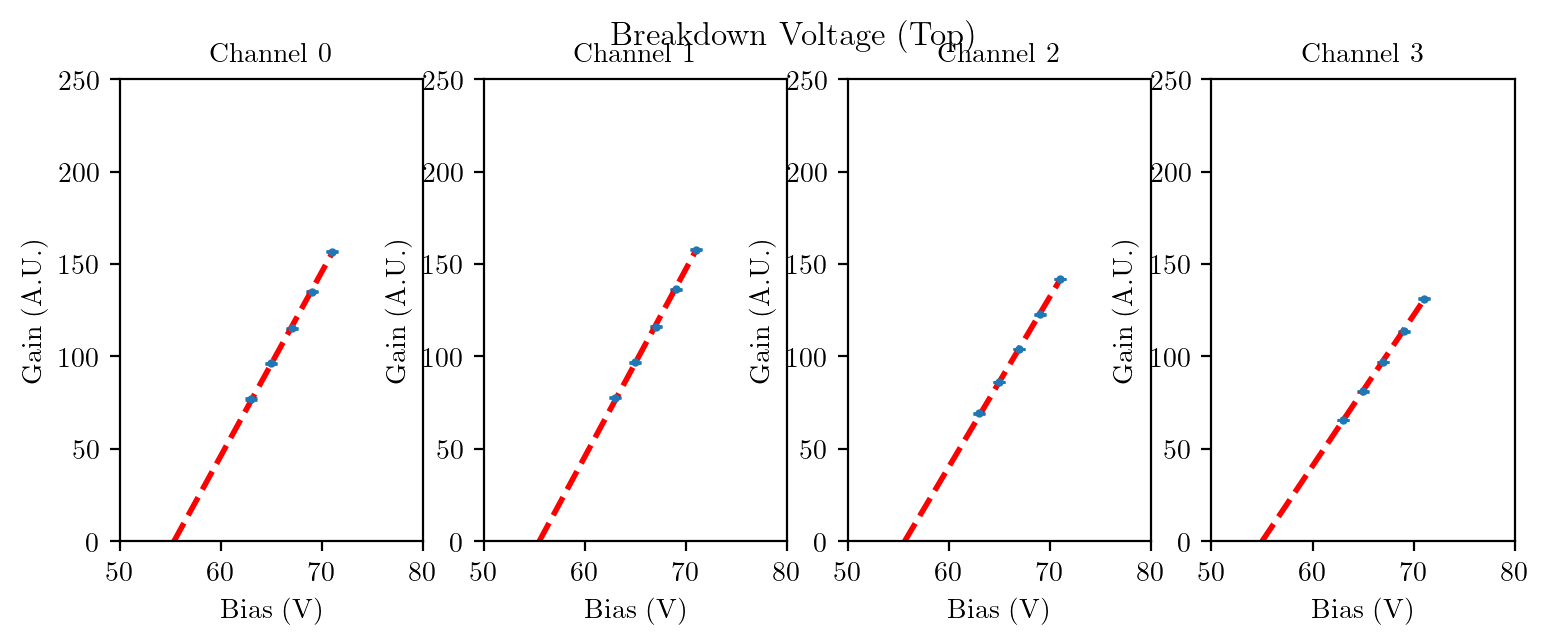

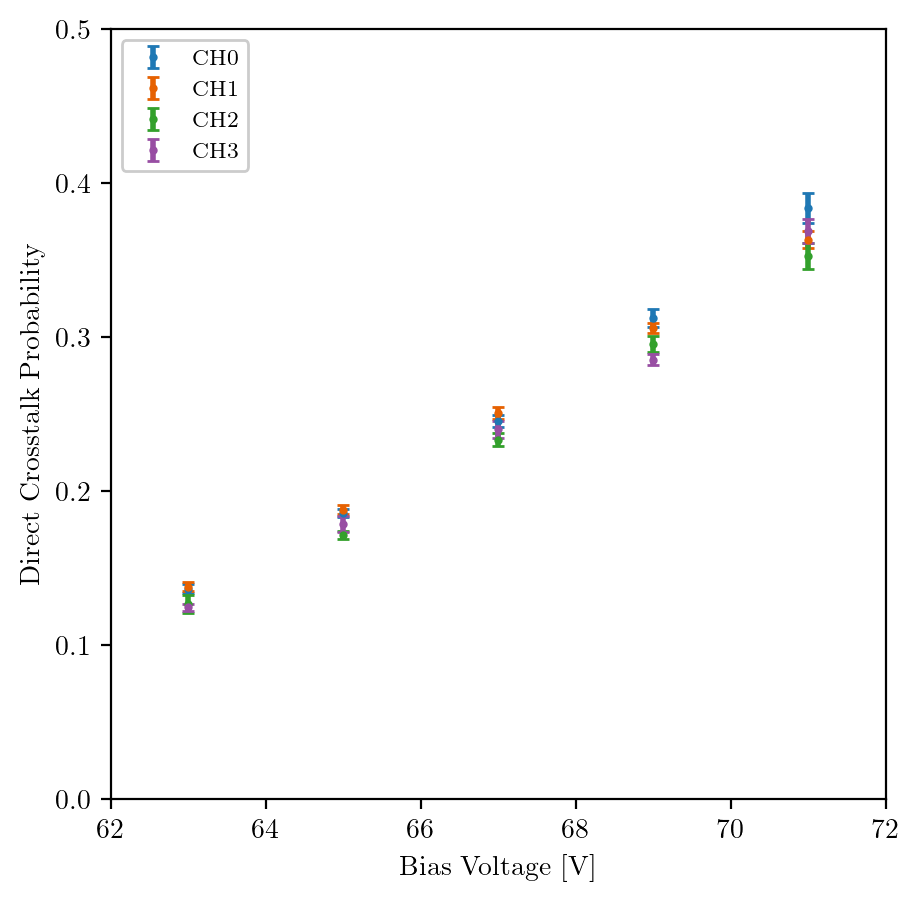

In [20]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(ds1122top):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-1e2,1.6e3,1600])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=90, prom=50, wid=15, dist=8)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
            if ipe==0:
                print('A1={:.3f} sigma1={:.3f}'.format(data.ch[ch].famp_hist_fit[0][1][0], data.ch[ch].famp_hist_fit[0][2][0]))
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 2, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        # print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].cumulative_nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in ds1122top], yerr=[data.ch[ch].ct[1] for data in ds1122top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in ds1122top]
    err = [data.ch[ch].q_a[1] for data in ds1122top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1122.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_famp_top_1122.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(62,72)
plt.ylim(0, 0.5)
plt.savefig('plots/sipm/dict_top_1122.pdf')

## Afterpulsing
Here we look at the raw waveform integrals over $5~\mu s$ ($I_{\rm long}$).<br>
They are grouped by the prompt filtered amplitude $A_{\rm filt}$.<br>
If $|A_{\rm filt}-A_k|<3\sigma_k$, assign $I_{\rm long}$ to $I_k$.<br>
$I_k$ is fitted by a Gaussian $(N_{k,\rm peak}, I_{k,\rm peak}, \sigma_{k,\rm peak})$.<br>
$(k, I_k)$ is fitted by a linear function $I_{k,\rm peak} = Q_{\rm peak}\times k + b$.<br>
Define $I_{k,\rm avg}\equiv \overline{I_{k}}$.<br>
$(k, I_{k, \rm avg})$ is fitted by a linear function $I_{k, \rm avg} = Q_{\rm avg} \times k + b$.<br>
Define afterpulse charge $Q_{\rm AP} \equiv \frac{Q_{\rm avg}}{Q_{\rm peak}}-1$.<br>
$Q_{\rm peak}$ is then fitted by the linear function for breakdown voltage $Q_{\rm peak} = C(V-V_{bd})$.<br>

ch0 63V 4PE 265-297
ch0 63V 3PE 221-253
ch0 63V 2PE 188-220
ch0 63V 1PE 141-171
ch0 63V 0PE 103-133
ch0 65V 5PE 355-397
ch0 65V 4PE 296-338
ch0 65V 3PE 254-298
ch0 65V 2PE 162-276
ch0 65V 1PE 151-195
ch0 65V 0PE 111-145
ch0 67V 5PE 403-453
ch0 67V 4PE 351-399
ch0 67V 3PE 279-327
ch0 67V 2PE 222-272
ch0 67V 1PE 166-206
ch0 67V 0PE 114-154
ch0 69V 6PE 500-572
ch0 69V 5PE 448-520
ch0 69V 4PE 368-436
ch0 69V 3PE 310-378
ch0 69V 2PE 237-305
ch0 69V 1PE 173-233
ch0 69V 0PE 103-163
ch0 71V 6PE 527-639
ch0 71V 5PE 463-575
ch0 71V 4PE 380-492
ch0 71V 3PE 302-404
ch0 71V 2PE 253-329
ch0 71V 1PE 184-248
ch0 71V 0PE 113-169
Channel 0 Vbd=53.641+/-0.424V slope=48.490+/-1.376
ch1 63V 6PE 351-389
ch1 63V 5PE 319-357
ch1 63V 4PE 270-306
ch1 63V 3PE 234-268
ch1 63V 2PE 187-221
ch1 63V 1PE 145-181
ch1 63V 0PE 105-137
ch1 65V 7PE 433-489
ch1 65V 6PE 410-452
ch1 65V 5PE 357-399
ch1 65V 4PE 293-351
ch1 65V 3PE 251-309
ch1 65V 2PE 206-250
ch1 65V 1PE 158-202
ch1 65V 0PE 106-148
ch1 67V 7PE 492-566
ch1 67V 6

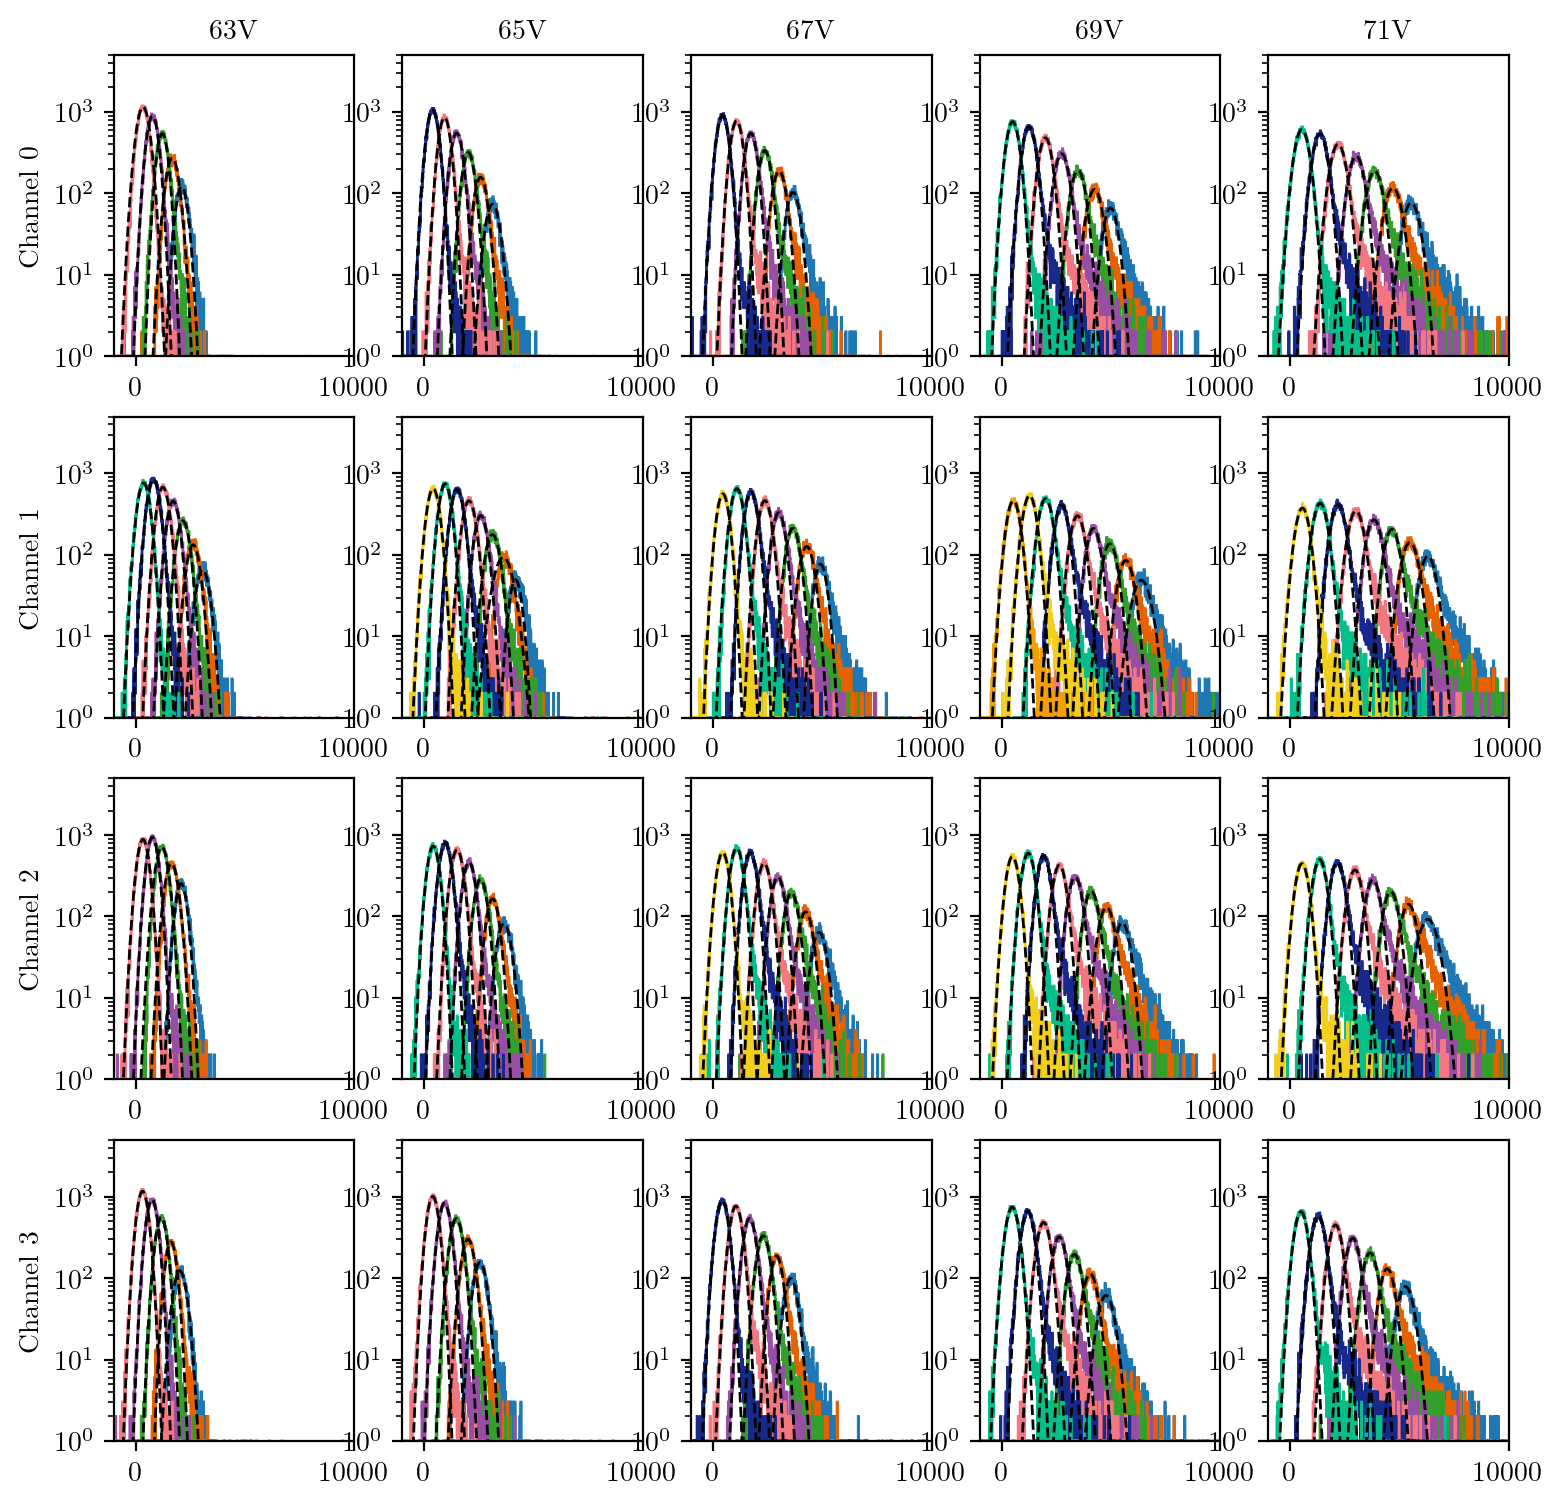

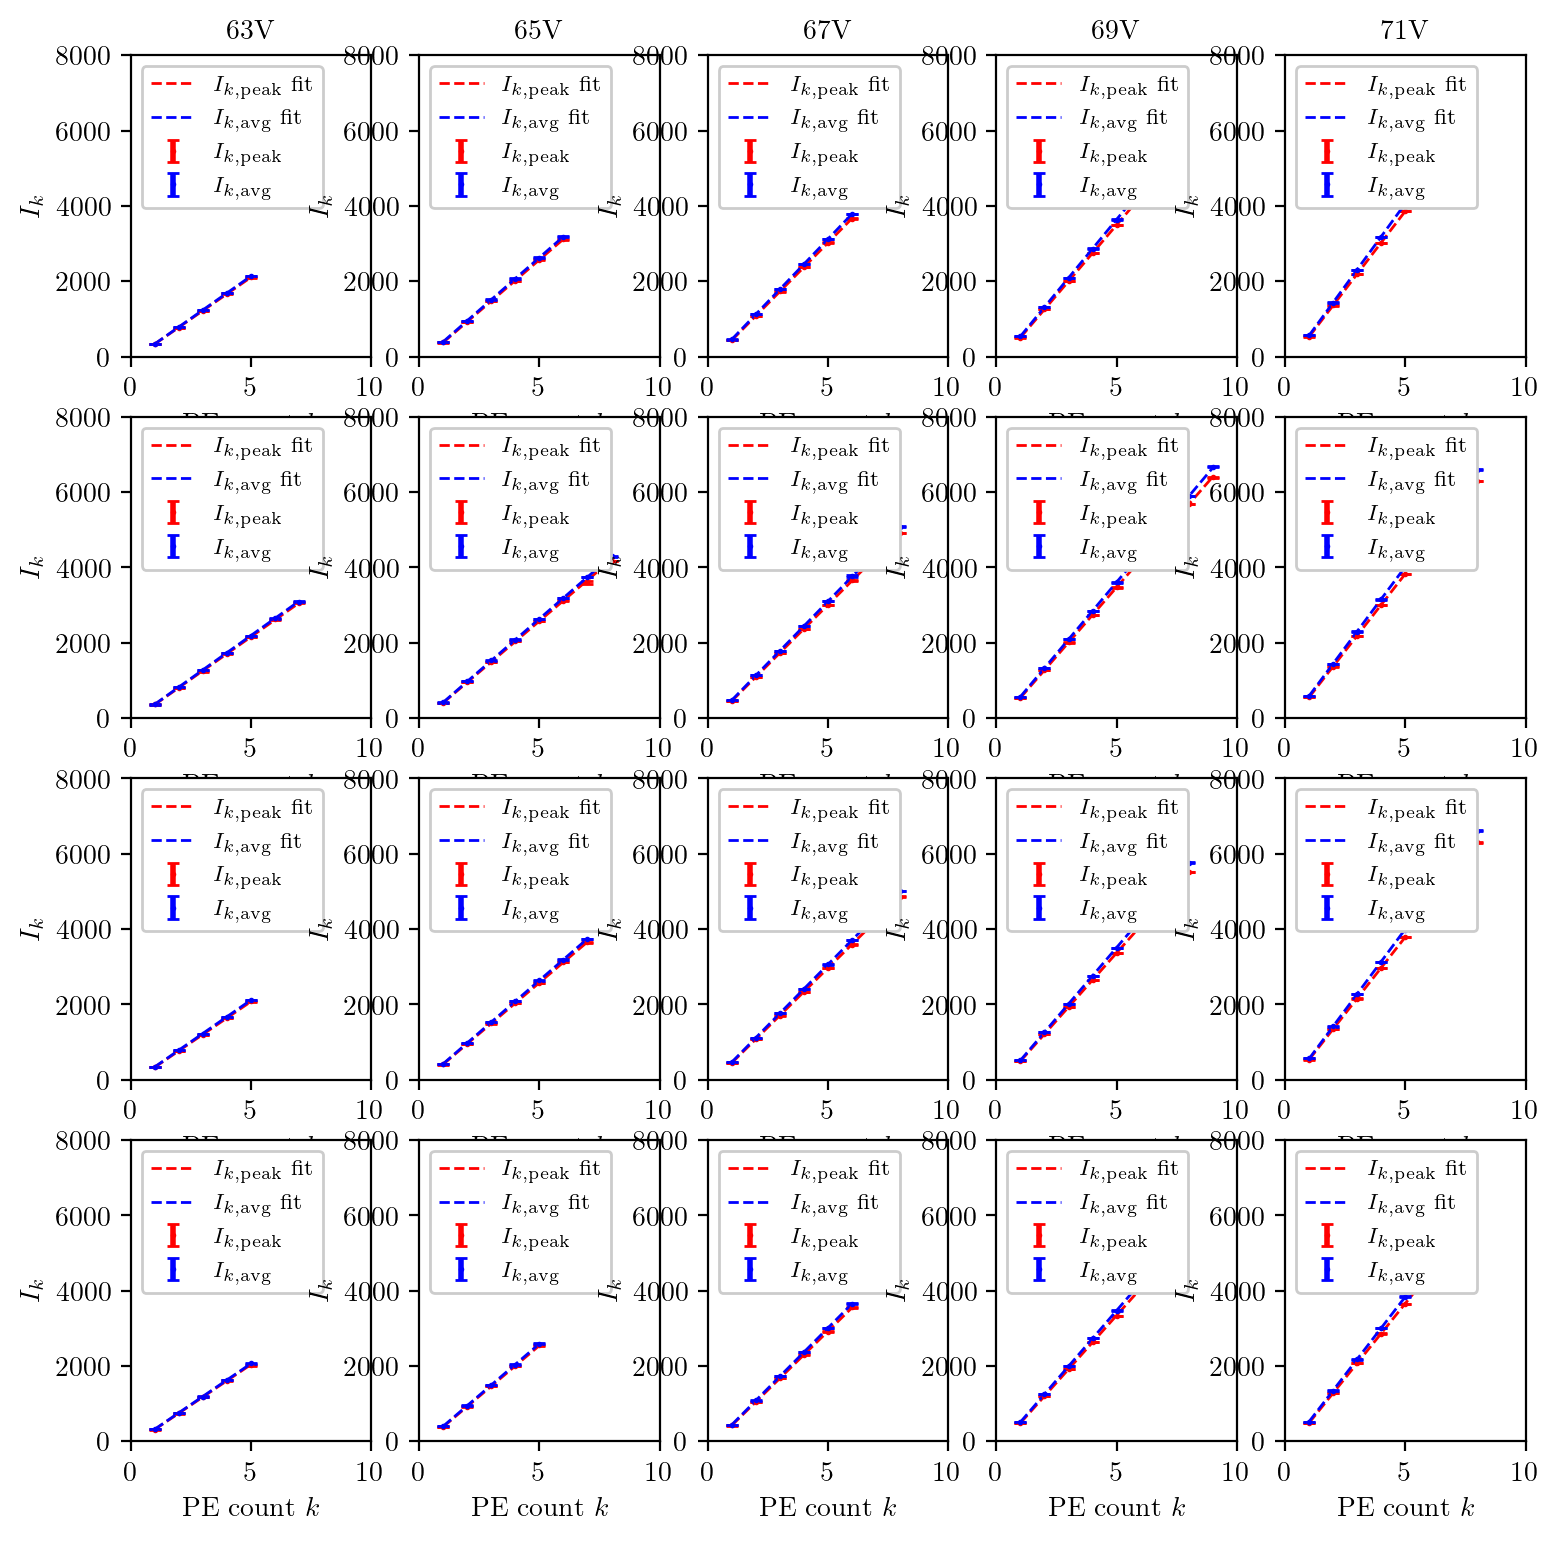

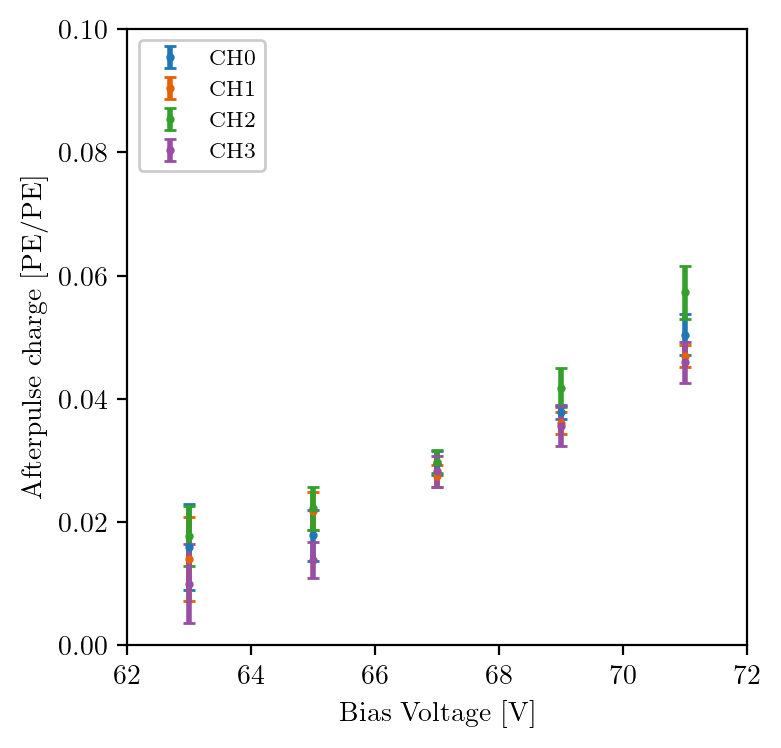

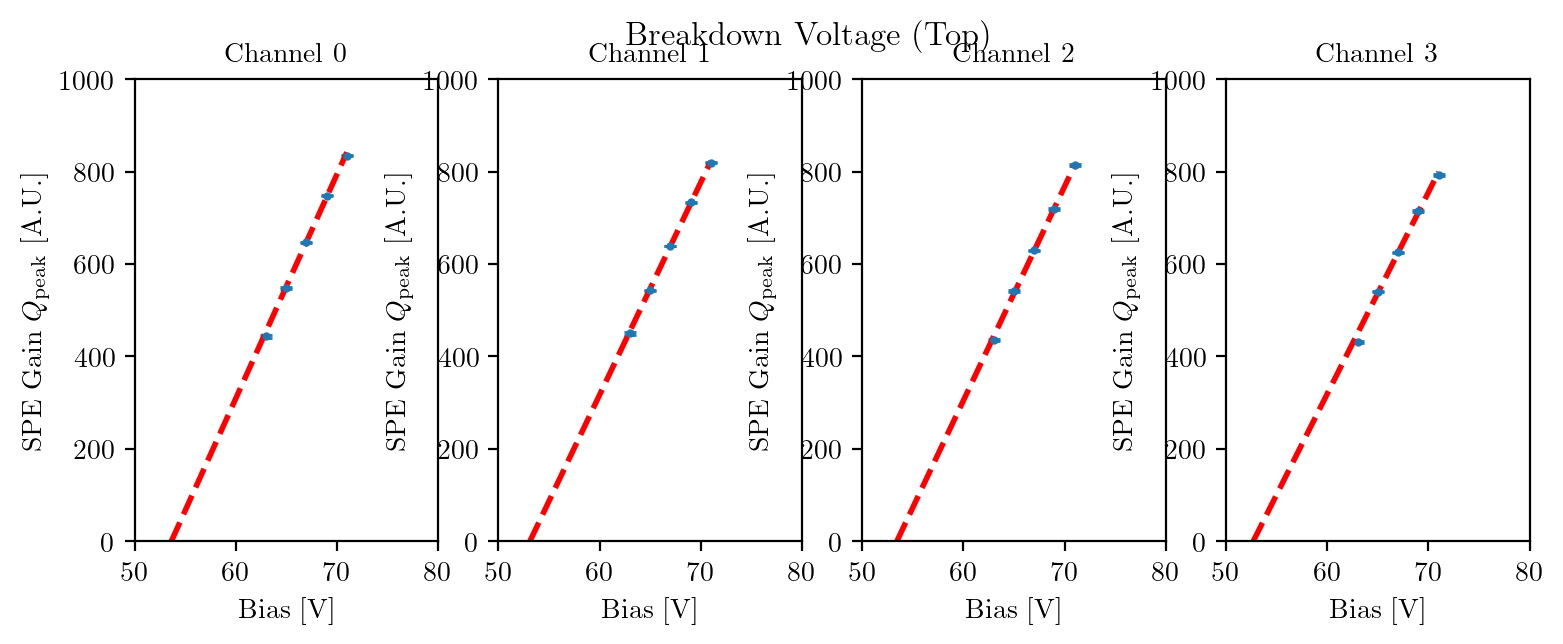

In [44]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_top = np.zeros((4,2))
x_min=-1000
x_max=1e4
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(ds1122top):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=3, bin=[x_min, x_max, n_bins])
        
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(0.65*np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>int(0.65*np.std(data.ch[ch].ap_charge[j+1])/bin_width) and j<len(data.ch[ch].ap_charge)-2:
                w=int(0.65*np.std(data.ch[ch].ap_charge[j+1])/bin_width) # something weird happened so I need to do this
            print('ch{} {}V {}PE {}-{}'.format(ch, bias[i], j, p-w,p+w))
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,5e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in ds1122top], yerr=[data.ch[ch].ap[1] for data in ds1122top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in ds1122top]
    err = [data.ch[ch].q_peak[1] for data in ds1122top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(62,72)
plt.ylim(0, 0.1)
plt.savefig('plots/sipm/afterpulse_bias_top_1122.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_charge_top_1122.pdf')

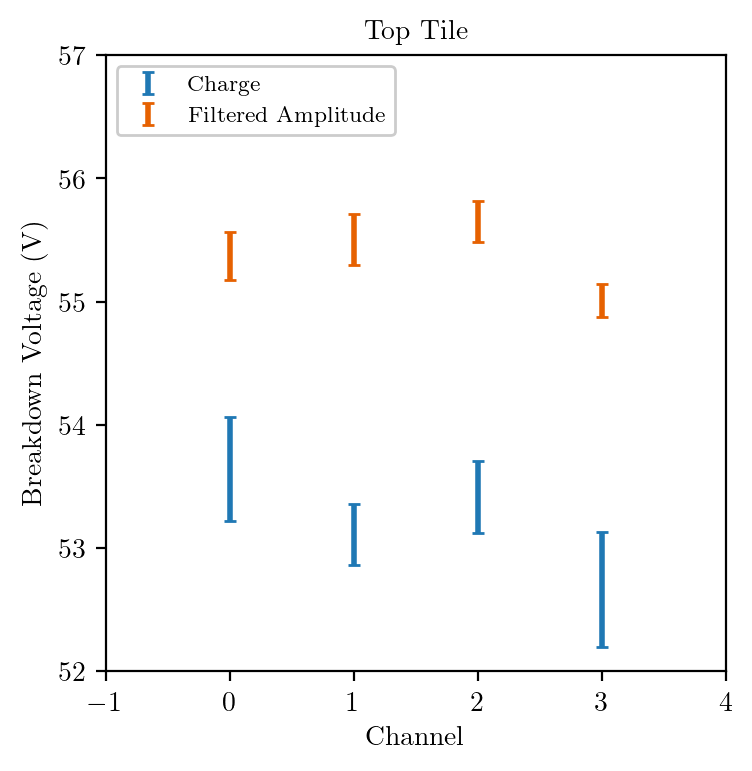

<Figure size 800x600 with 0 Axes>

In [29]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(52,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_top_1122.pdf')

# Bottome tile calibration (1122 data)

## Load data

In [9]:
bias = [63, 65, 67, 69, 71]
ds1122bot = []
for i,volt in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    file = ROOT.TFile("root/calibration_1122_{}V_bottom.root".format(volt), "read")
    tree = file.Get("tree")
    nev = 0
    for iev,ev in enumerate(tree):
        nev += 1
        for ich,ch in enumerate(dset.ch):
            ch.baseline_avg.append(ev.bsl_avg[ich])
            ch.baseline_med.append(ev.bsl_med[ich])
            ch.baseline_std.append(ev.bsl_std[ich])
            ch.acquisition_max.append(ev.acq_max[ich])
            ch.acquisition_min.append(ev.acq_min[ich])
            ch.famp.append(ev.fil_amp[ich])
            ch.integral_long.append(ev.int_long[ich])
    print('Bottom {}V {} events loaded'.format(volt, nev))
    for ch in dset.ch:
        ch.cumulative_nevents = nev
    ds1122bot.append(dset)

Bottom 63V 219820 events loaded
Bottom 65V 219811 events loaded
Bottom 67V 219809 events loaded
Bottom 69V 219821 events loaded
Bottom 71V 219799 events loaded


## Plot filtered amplitude histogram and analyze

A1=66.967 sigma1=8.560
A1=82.942 sigma1=9.661
A1=103.689 sigma1=11.146
A1=122.873 sigma1=12.141
A1=133.838 sigma1=13.253
Channel 0 Vbd=55.312+/-0.218V slope=9.223+/-0.180
A1=58.540 sigma1=7.905
A1=71.395 sigma1=8.045
A1=82.328 sigma1=8.342
A1=97.702 sigma1=9.120
A1=114.070 sigma1=9.781
Channel 1 Vbd=55.442+/-0.124V slope=7.692+/-0.072
A1=63.275 sigma1=7.696
A1=80.170 sigma1=8.037
A1=93.372 sigma1=8.361
A1=108.221 sigma1=9.096
A1=125.977 sigma1=10.346
Channel 2 Vbd=55.694+/-0.143V slope=8.759+/-0.106
A1=66.153 sigma1=9.567
A1=85.228 sigma1=9.638
A1=101.930 sigma1=10.913
A1=118.014 sigma1=11.132
A1=134.172 sigma1=11.867
Channel 3 Vbd=55.052+/-0.252V slope=8.618+/-0.216


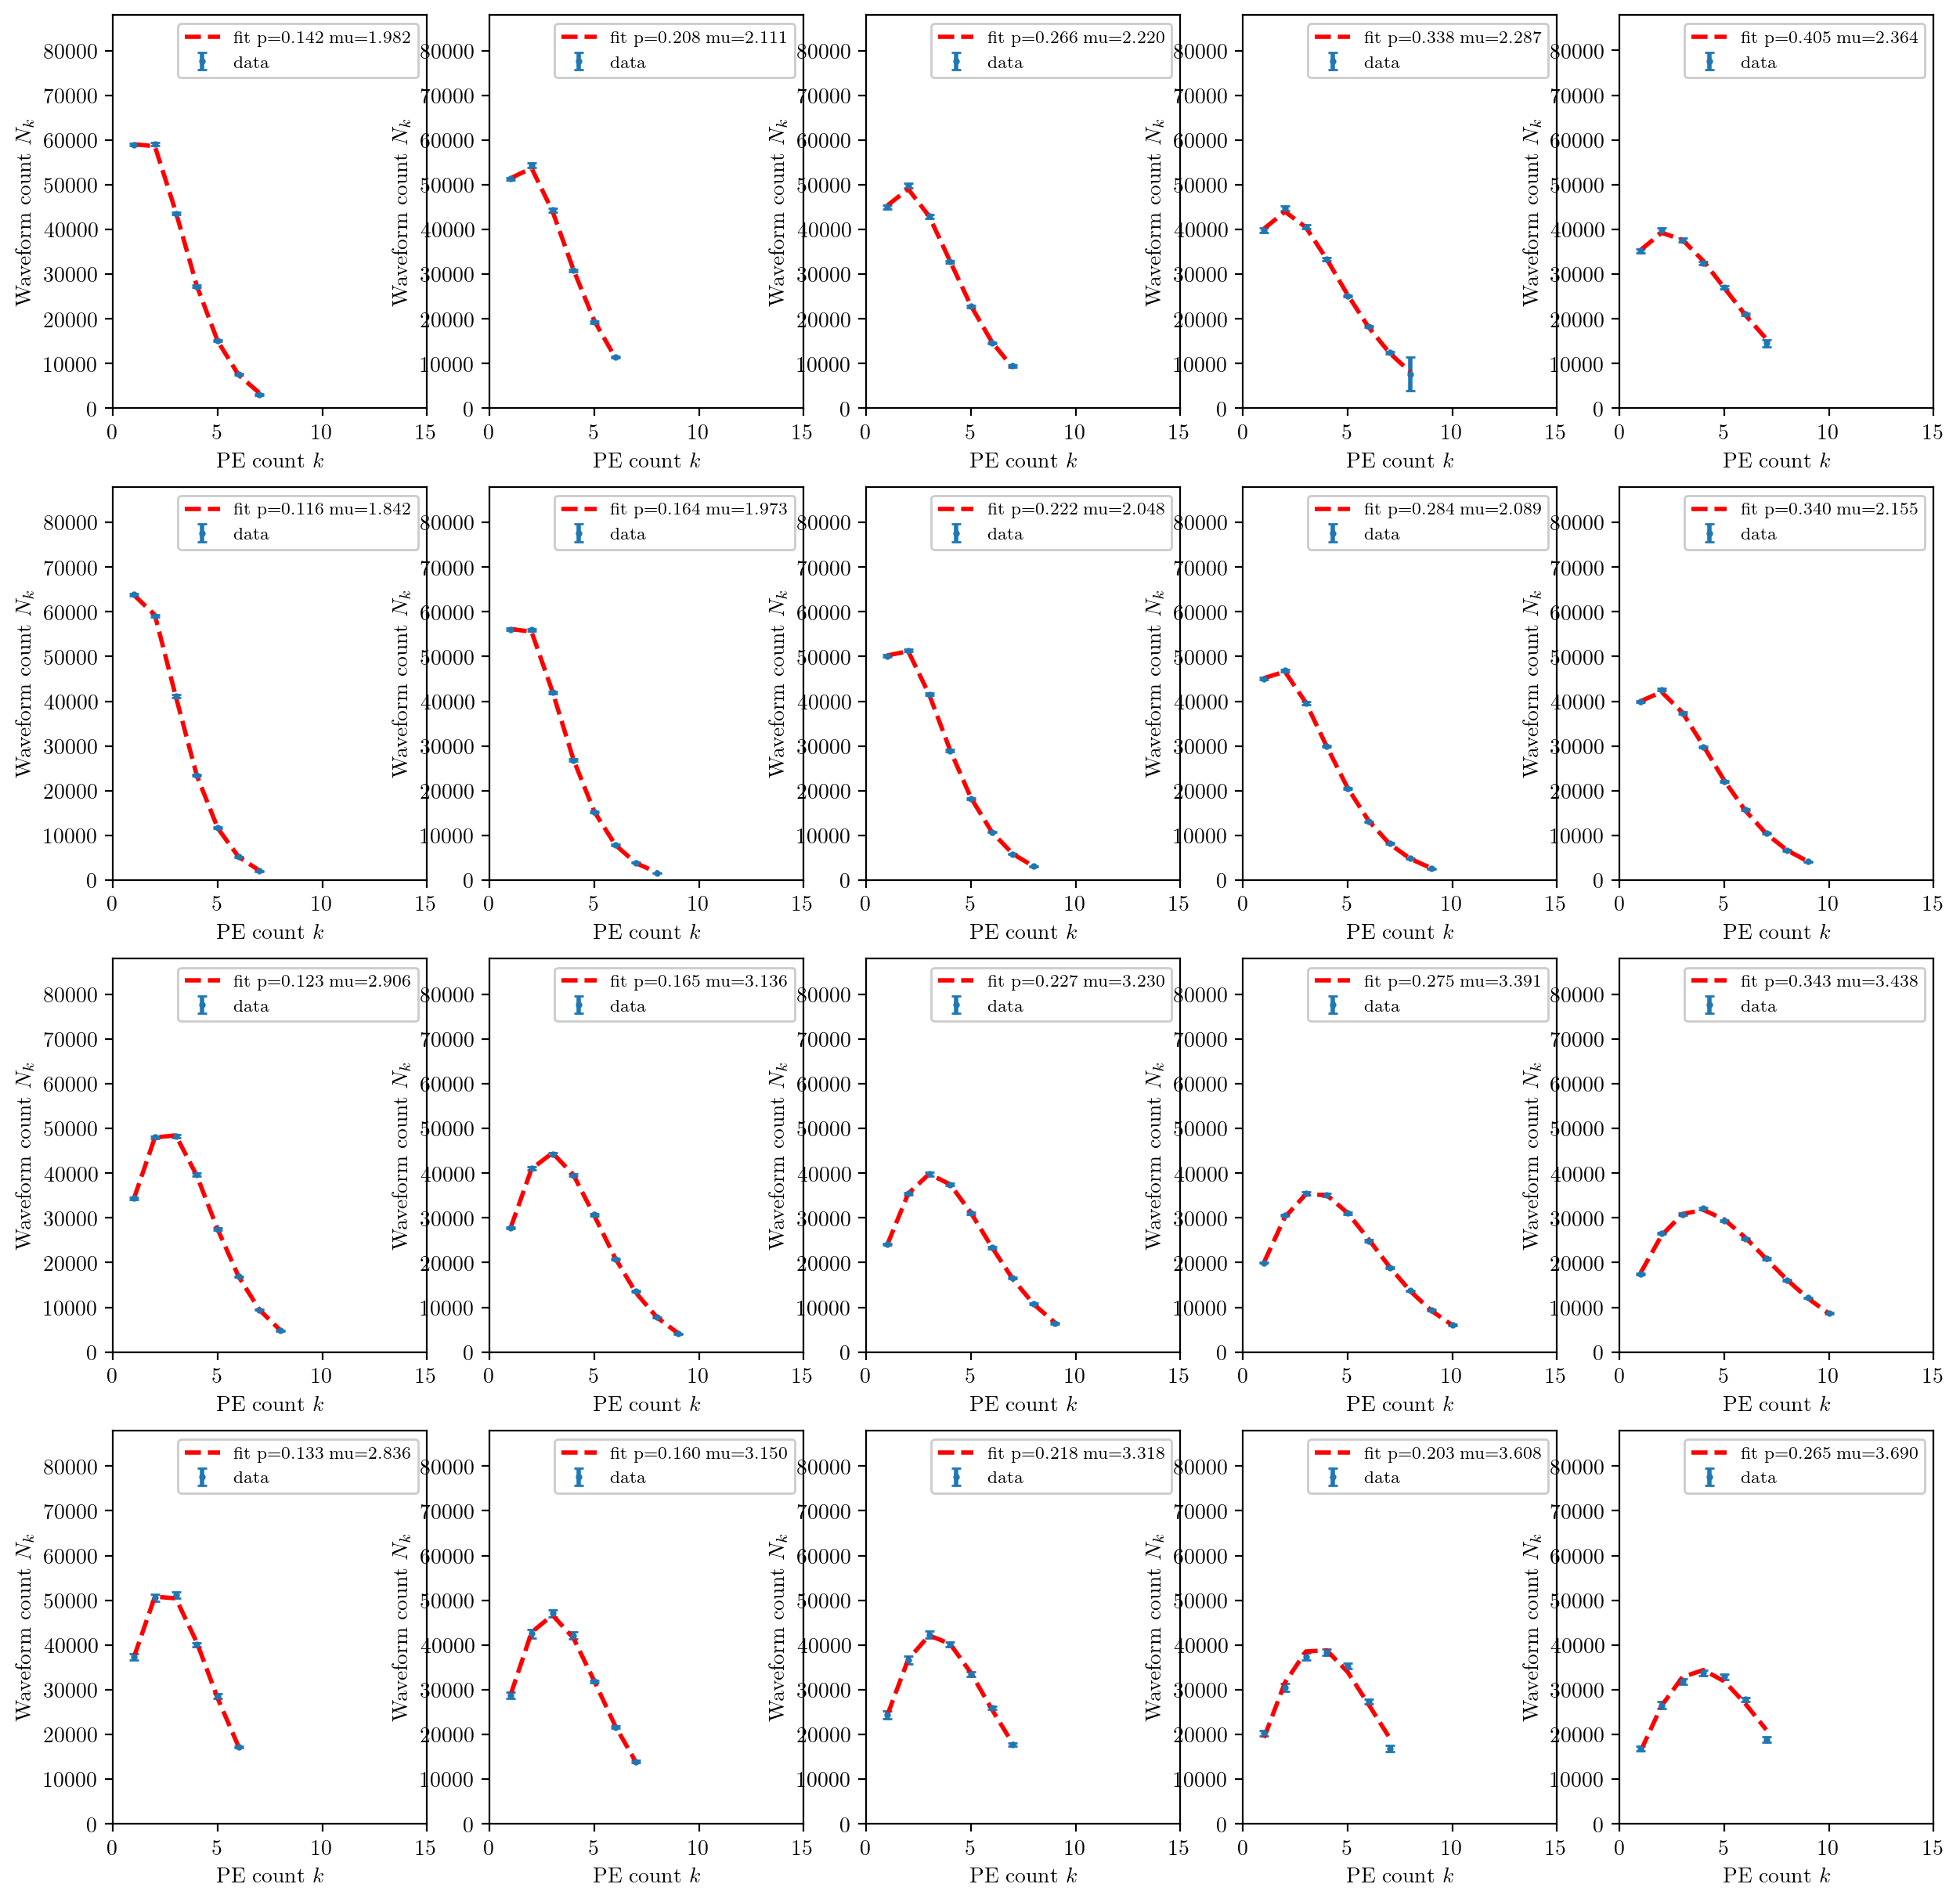

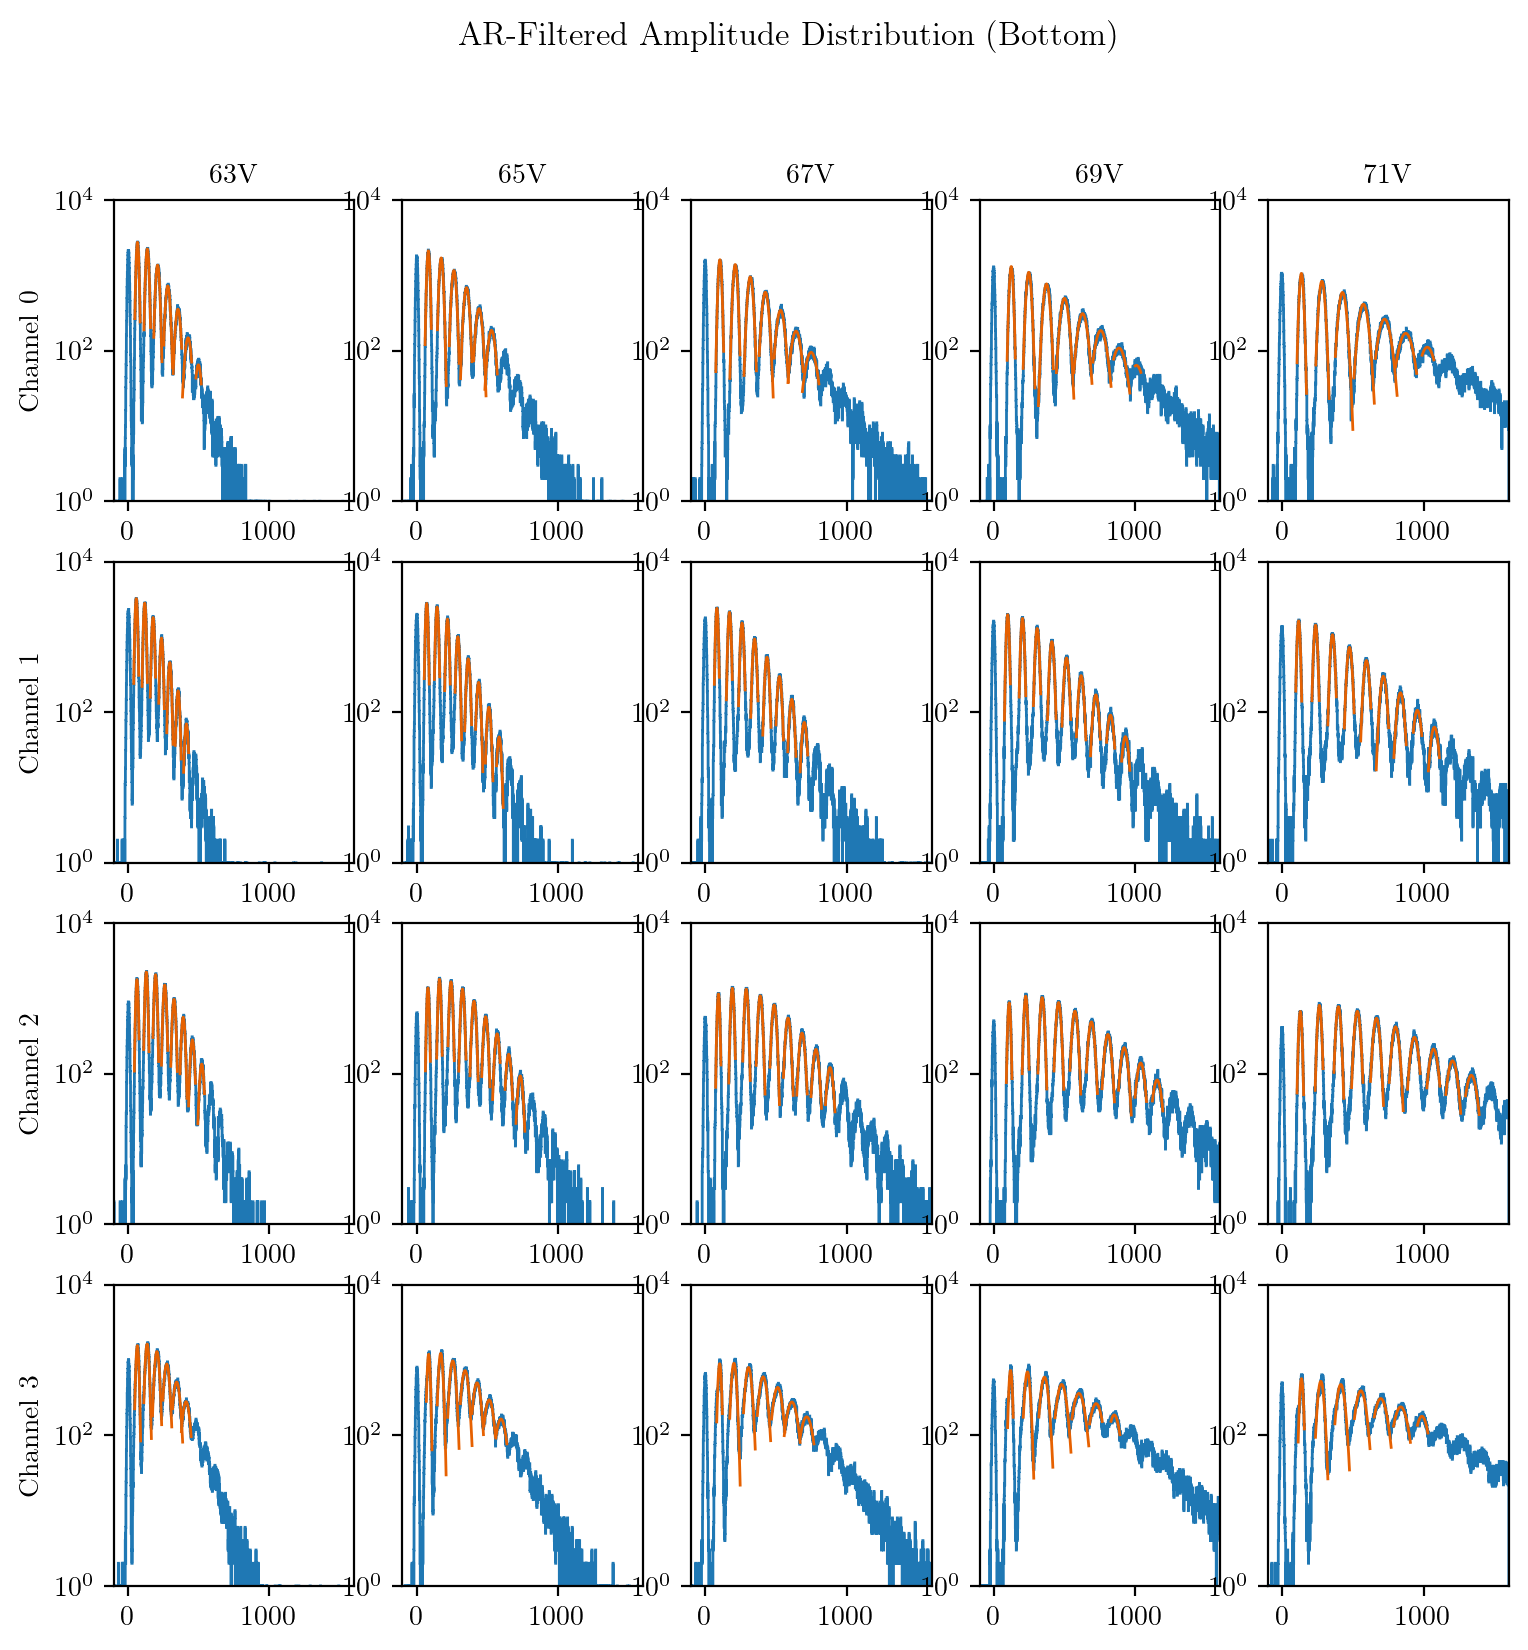

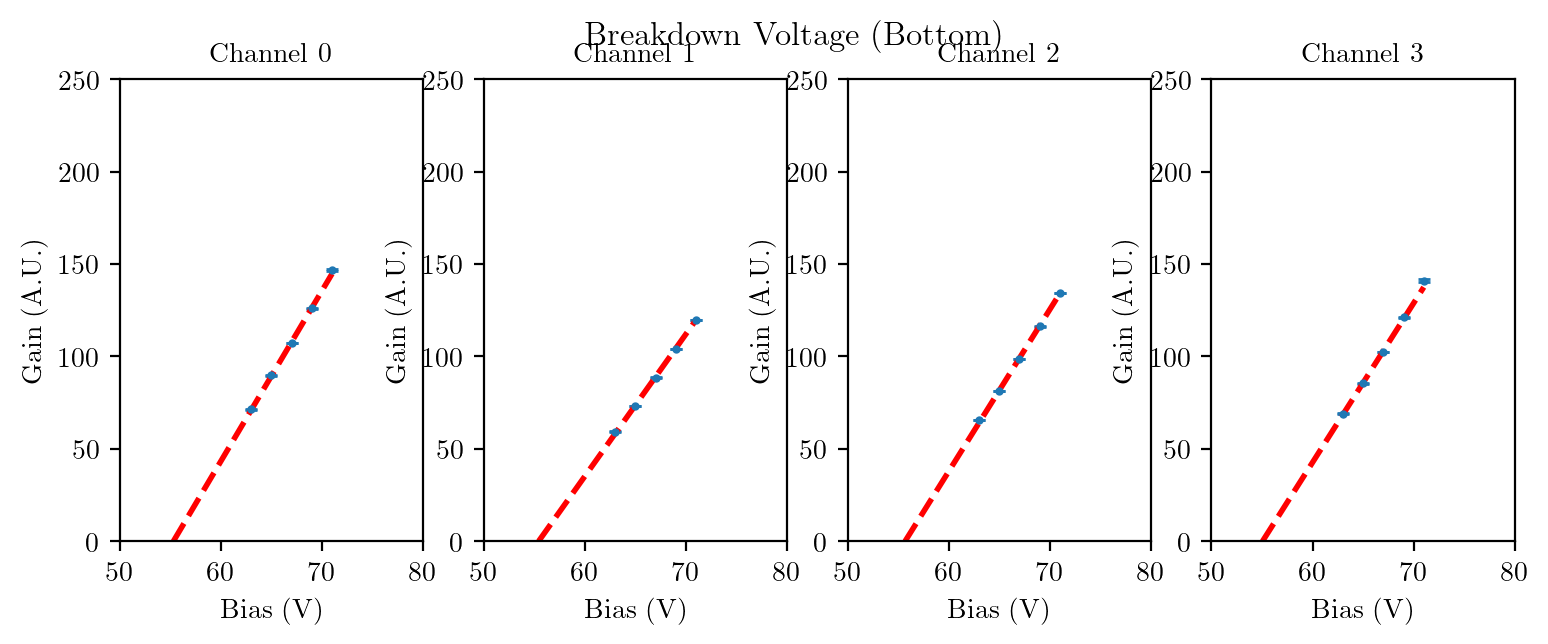

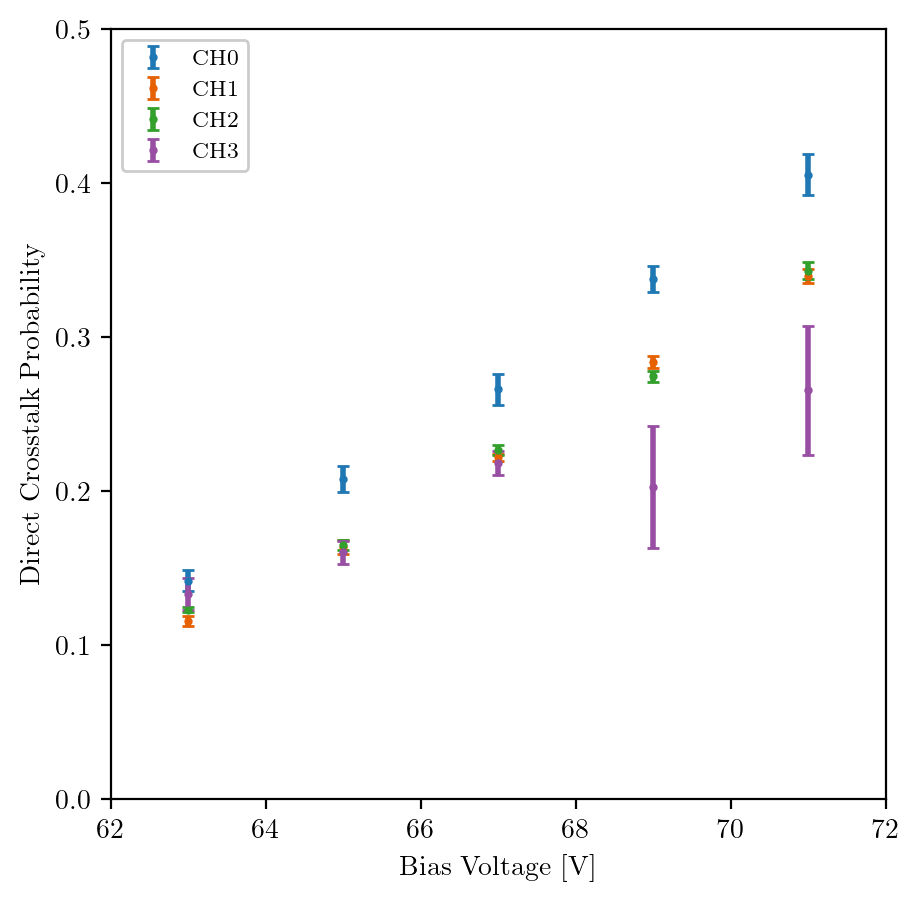

In [17]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_bot = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(ds1122bot):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-1e2,1.6e3,1500])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=120, prom=50, wid=15, dist=8)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
            if ipe==0:
                print('A1={:.3f} sigma1={:.3f}'.format(data.ch[ch].famp_hist_fit[0][1][0], data.ch[ch].famp_hist_fit[0][2][0]))
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        # print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].cumulative_nevents)
        plt.xlim(0,15)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in ds1122bot], yerr=[data.ch[ch].ct[1] for data in ds1122bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in ds1122bot]
    err = [data.ch[ch].q_a[1] for data in ds1122bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1122.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_famp_bot_1122.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(62,72)
plt.ylim(0, 0.5)
plt.savefig('plots/sipm/dict_bot_1122.pdf')

## Afterpulsing


w=20 last_w=31
ch0 63V 5PE 292-354
w=19 last_w=31
ch0 63V 4PE 252-314
w=24 last_w=31
ch0 63V 3PE 208-270
w=45 last_w=31
ch0 63V 2PE 169-231
w=25 last_w=31
ch0 63V 1PE 122-184
w=43 last_w=31
ch0 63V 0PE 91-153
w=28 last_w=30
ch0 65V 4PE 288-348
w=90 last_w=30
ch0 65V 3PE 239-299
w=359 last_w=30
ch0 65V 2PE 189-249
w=232 last_w=30
ch0 65V 1PE 140-200
w=21 last_w=30
ch0 65V 0PE 97-157
w=100 last_w=131
ch0 67V 5PE 374-454
w=46 last_w=40
ch0 67V 4PE 316-396
w=42 last_w=40
ch0 67V 3PE 262-342
w=84 last_w=40
ch0 67V 2PE 198-278
w=98 last_w=40
ch0 67V 1PE 147-227
w=38 last_w=40
ch0 67V 0PE 84-164
w=71 last_w=63
ch0 69V 6PE 506-586
w=40 last_w=40
ch0 69V 5PE 428-508
w=55 last_w=40
ch0 69V 4PE 364-444
w=395 last_w=40
ch0 69V 3PE 298-378
w=146 last_w=40
ch0 69V 2PE 224-304
w=72 last_w=40
ch0 69V 1PE 160-240
w=48 last_w=40
ch0 69V 0PE 93-173
w=90 last_w=100
ch0 71V 5PE 467-547
w=68 last_w=40
ch0 71V 4PE 393-473
w=101 last_w=40
ch0 71V 3PE 316-396
w=115 last_w=40
ch0 71V 2PE 243-323
w=57 last_w=40


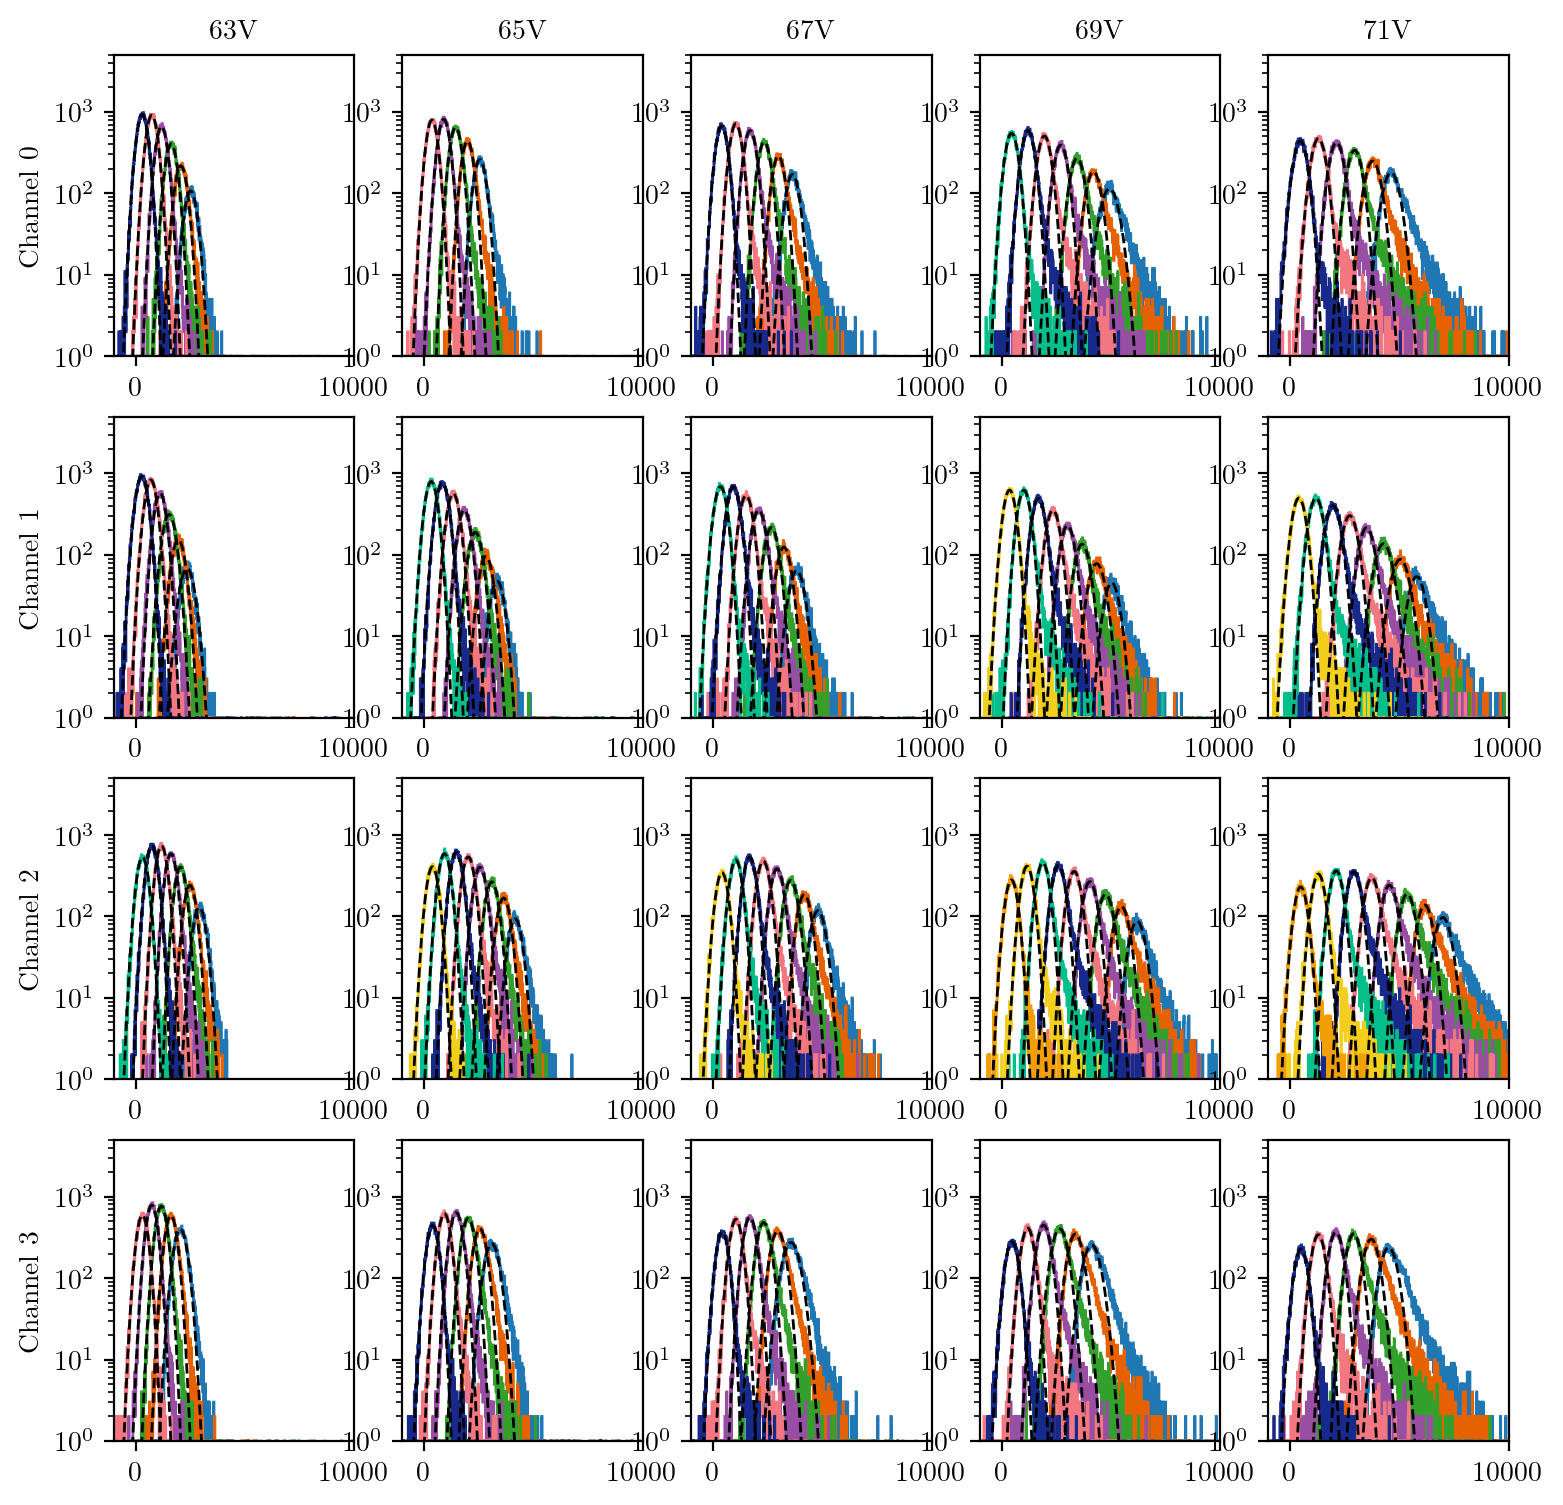

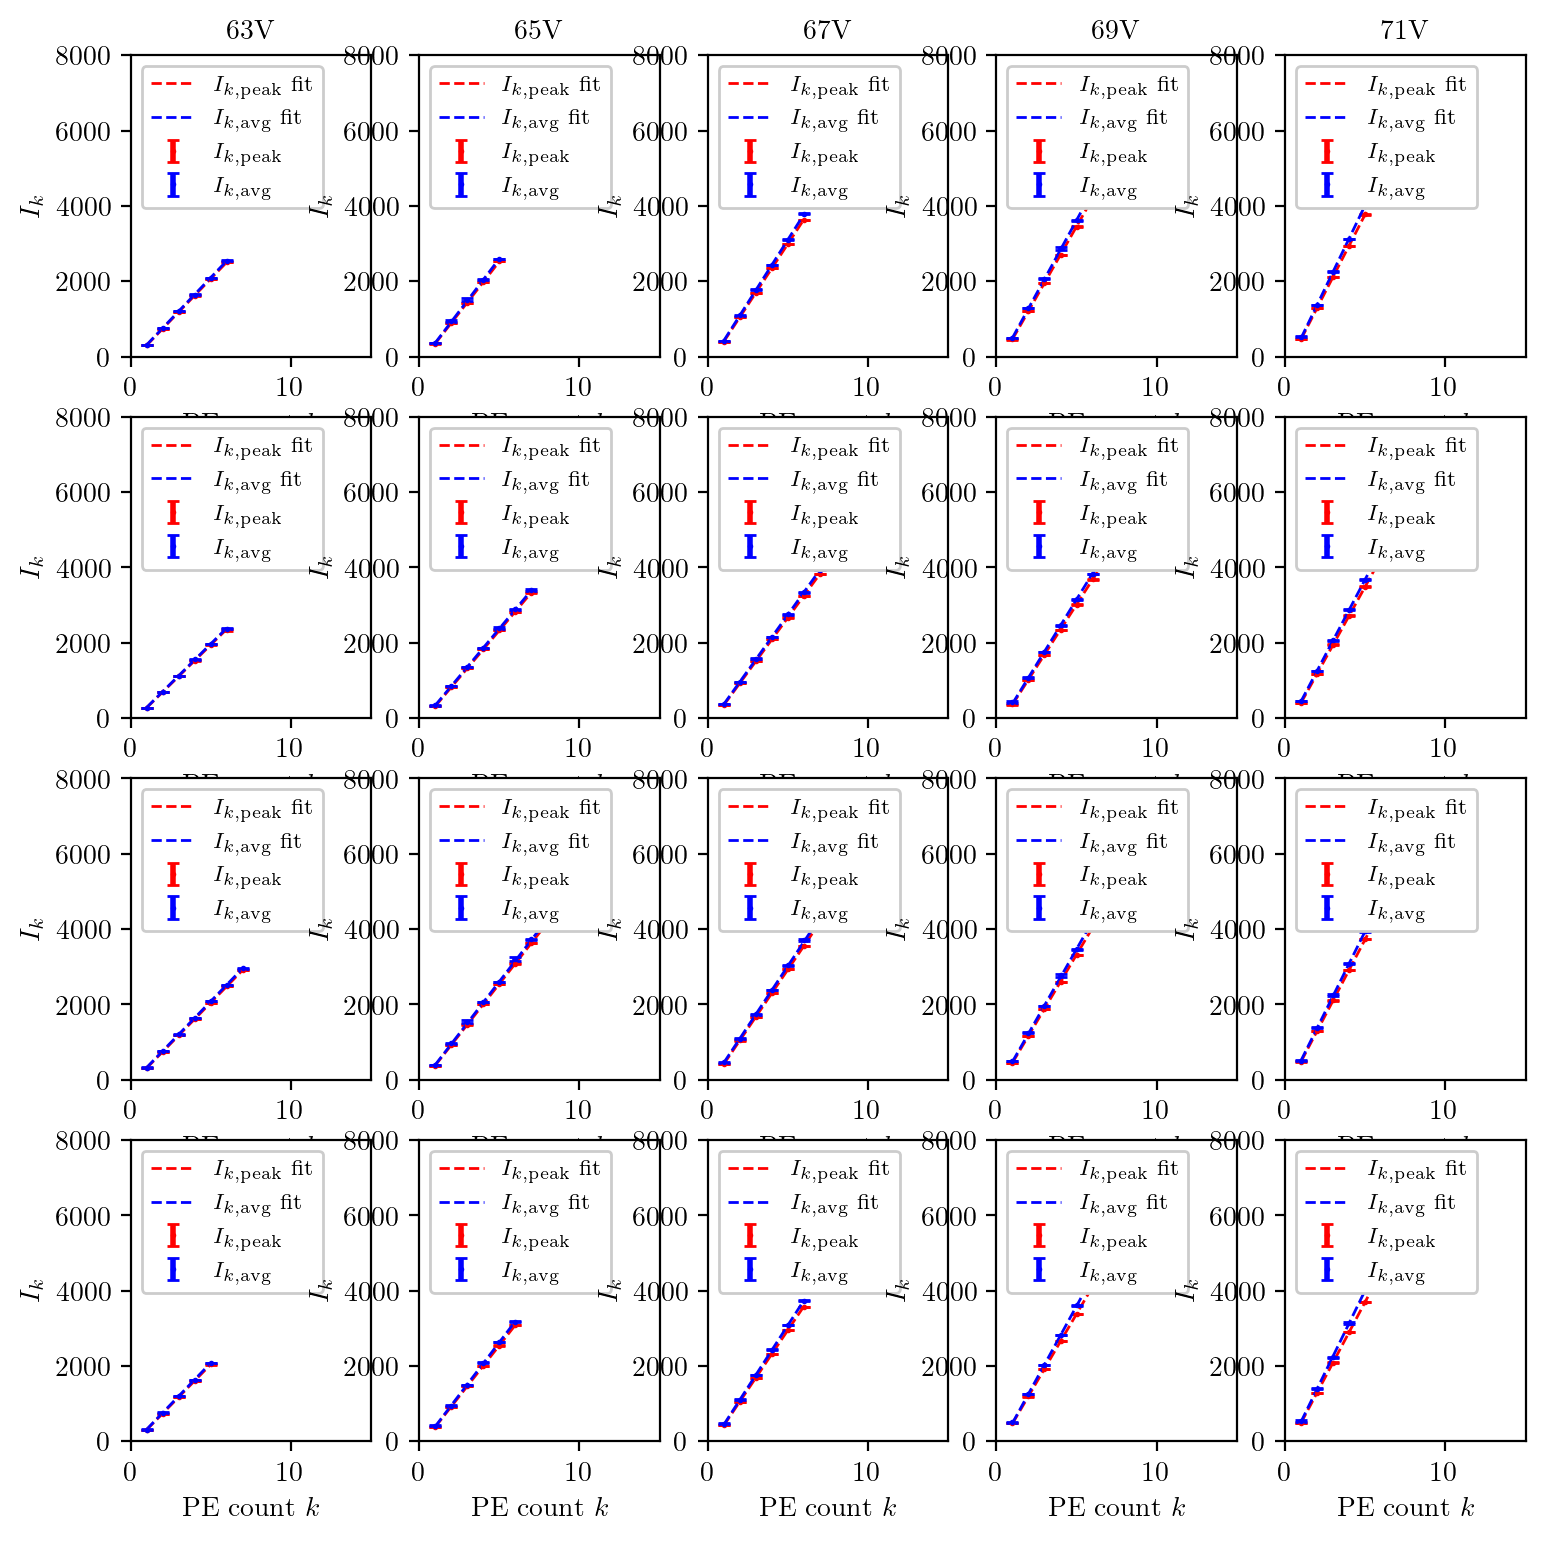

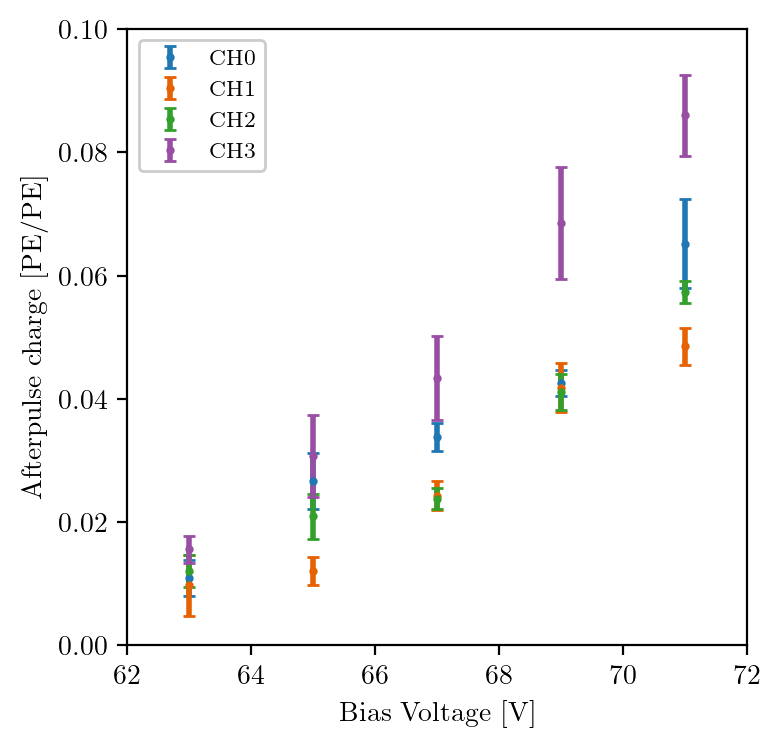

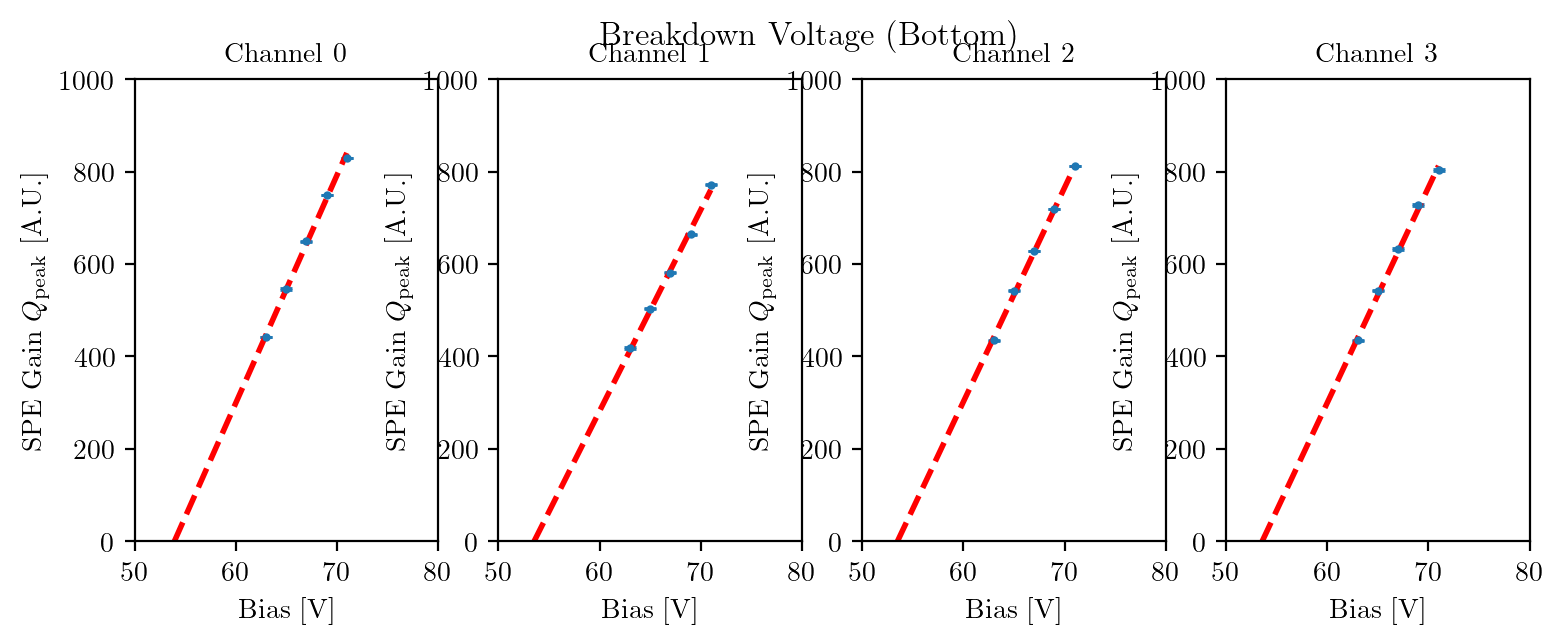

In [43]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_bot = np.zeros((4,2))
x_min=-1000
x_max=1e4
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(ds1122bot):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=2, bin=[x_min, x_max, n_bins])
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        last_w = int(0.6*np.std(data.ch[ch].ap_charge[-1])/bin_width)
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(0.6*np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(0.9*data.ch[ch].ap_charge_hist[j]) # in bins
            print('w={} last_w={}'.format(w, last_w))
            w=min(last_w,40) # something weird happened so I need to do this
            print('ch{} {}V {}PE {}-{}'.format(ch, bias[i], j, p-w,p+w))
            last_w = w
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,5e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,15)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in ds1122bot], yerr=[data.ch[ch].ap[1] for data in ds1122bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in ds1122bot]
    err = [data.ch[ch].q_peak[1] for data in ds1122bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(62,72)
plt.ylim(0, 0.1)
plt.savefig('plots/sipm/afterpulse_bias_bot_1122.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_charge_bot_1122.pdf')

# Breakdown voltage summary

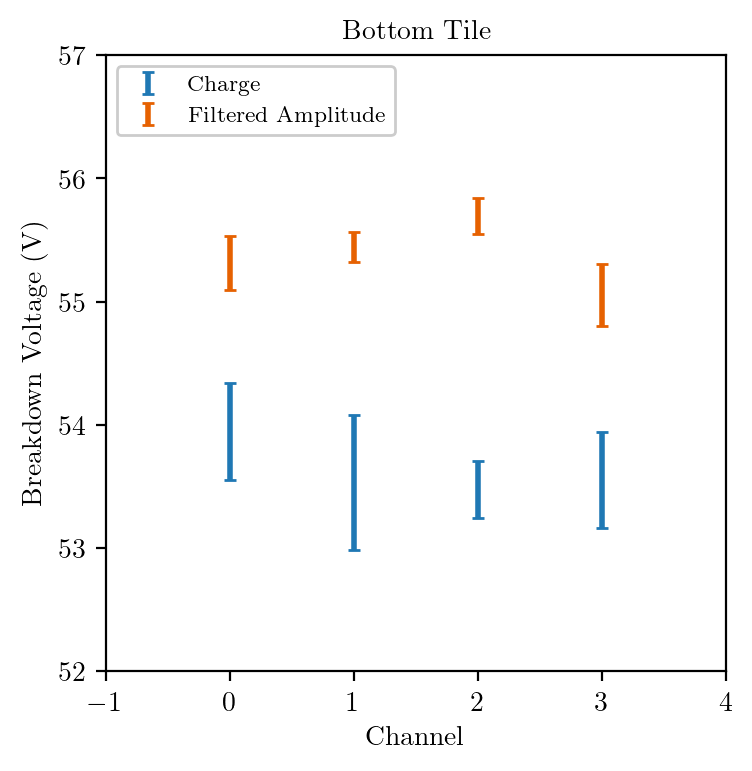

<Figure size 800x600 with 0 Axes>

In [45]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bot[:,0], yerr=Vbd_charge_bot[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bot[:,0], yerr=Vbd_famp_bot[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(52,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_bot_1122.pdf')

In [46]:
import csv
for i,v in enumerate(bias):
    with open('calibration_1122_{}V.csv'.format(v), 'w') as f:
        w = csv.writer(f)
        w.writerow(['CH', 'A1', 'sigma1', 'p', 'p_err', 'Qavg', 'Qavg_err', 'Qpeak', 'Qpeak_err', 'Qap', 'Qap_err'])
        for ch in range(4):
            dset = ds1122top[i].ch[ch]
            row = ['T{}'.format(ch)]
            row += [str(dset.famp_hist_fit[0][1][0]), str(dset.famp_hist_fit[0][2][0])]
            row += [str(dset.ct[0]), str(dset.ct[1])]
            row += [str(dset.q_avg[0]), str(dset.q_avg[1])]
            row += [str(dset.q_peak[0]), str(dset.q_peak[1])]
            row += [str(dset.ap[0]), str(dset.ap[1])]
            w.writerow(row)
        for ch in range(4):
            dset = ds1122bot[i].ch[ch]
            row = ['B{}'.format(ch)]
            row += [str(dset.famp_hist_fit[0][1][0]), str(dset.famp_hist_fit[0][2][0])]
            row += [str(dset.ct[0]), str(dset.ct[1])]
            row += [str(dset.q_avg[0]), str(dset.q_avg[1])]
            row += [str(dset.q_peak[0]), str(dset.q_peak[1])]
            row += [str(dset.ap[0]), str(dset.ap[1])]
            w.writerow(row)

## SPE average waveform
Take waveforms with prompt filtered amplitude $|A-A_k|<2\sigma_k$ for $k=1$ and take average.<br>
At $k=1$ PE, afterpulses can be ignored.<br>
The average waveform is fitted by
$$h(t,t') = A_1 e^{-(t-t')/\tau_1} + A_2 e^{-(t-t')/\tau2}$$

# Try to include time jitter
SiPM pulse (single component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$

## Top

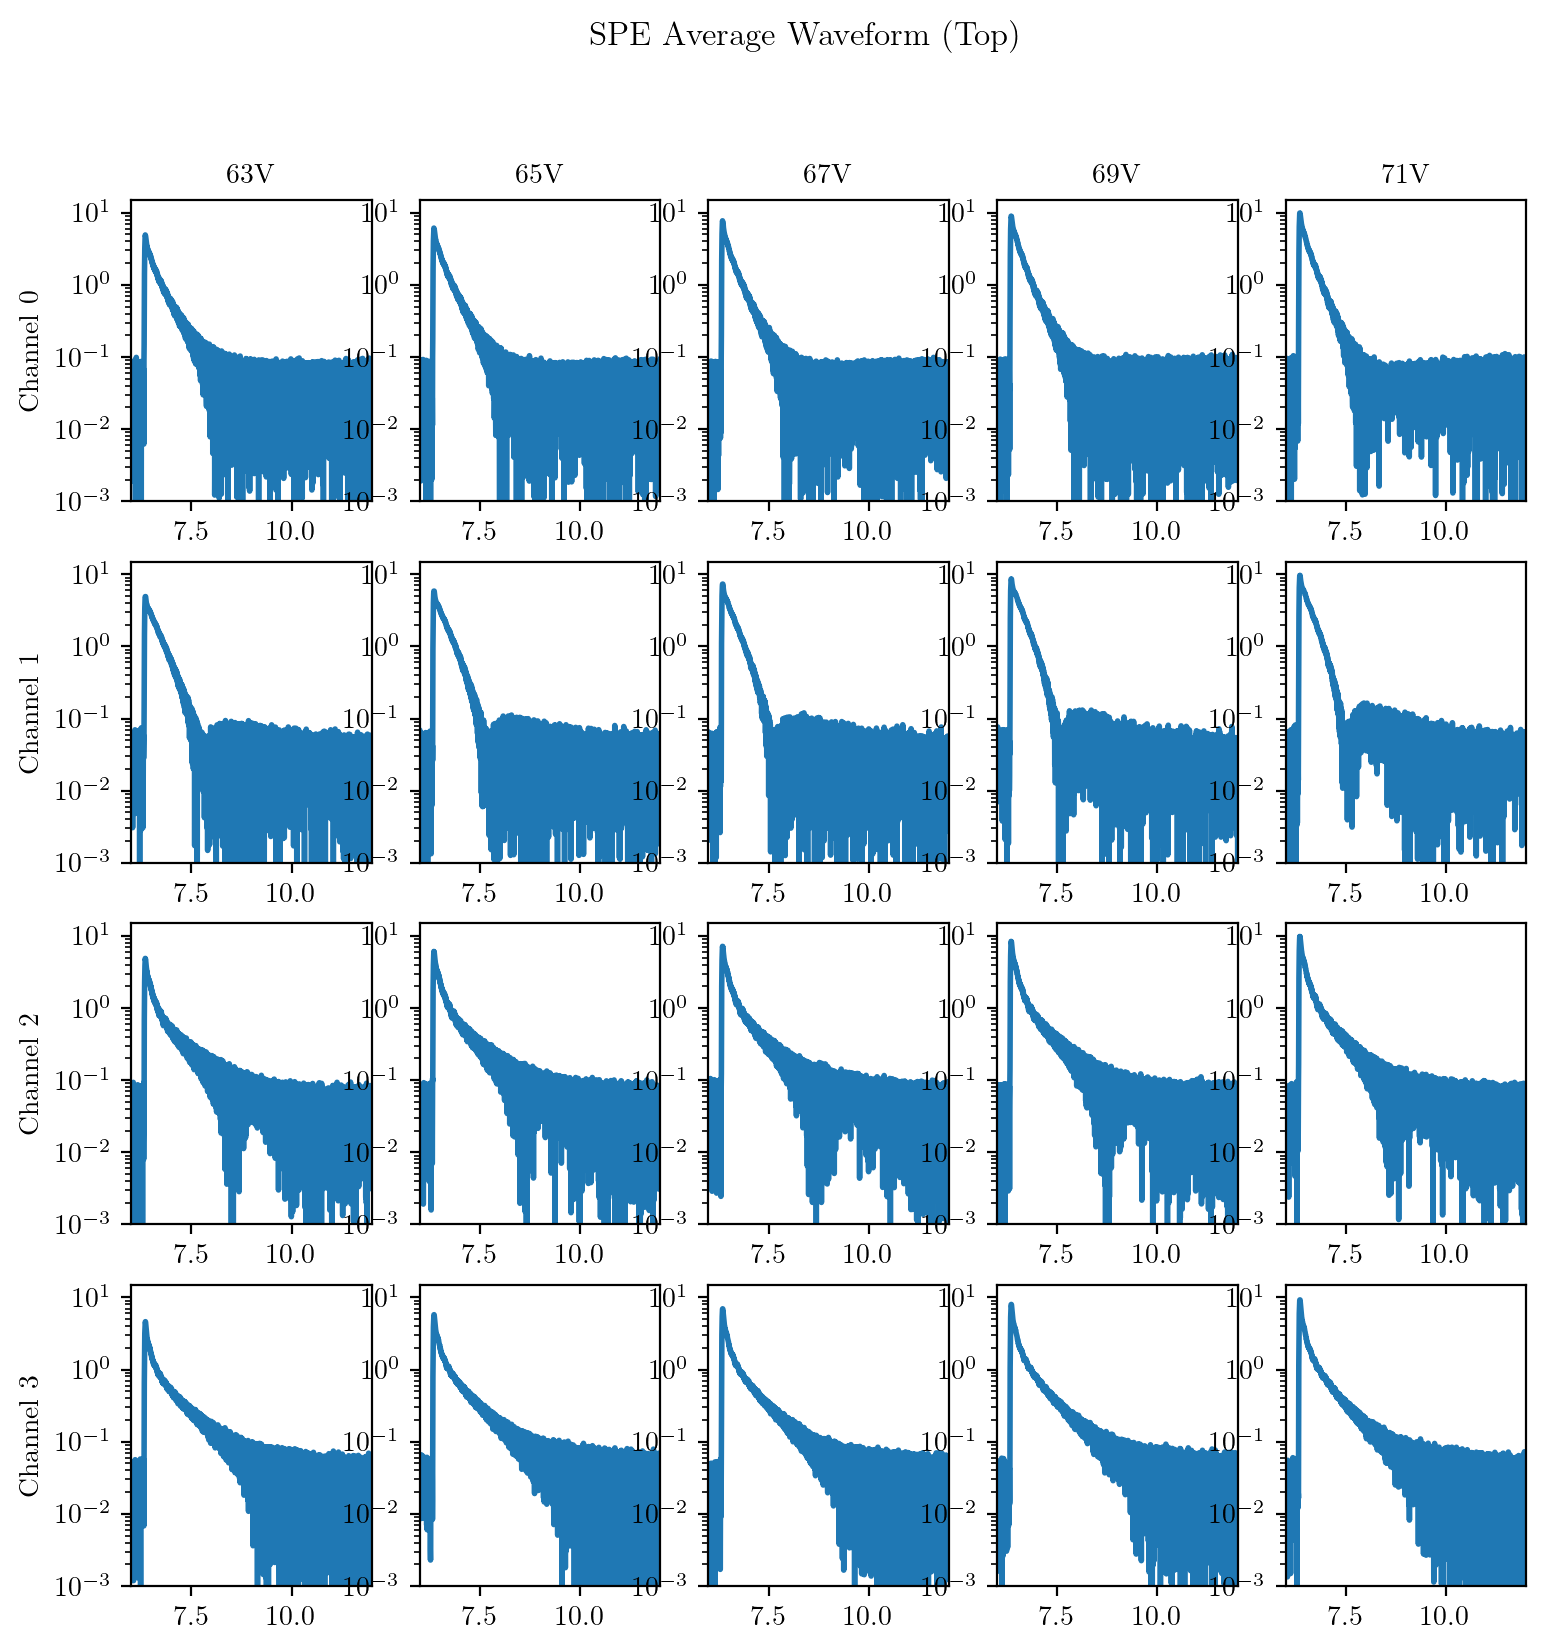

In [47]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for i,v in enumerate(bias):
    file = ROOT.TFile('root/SPE_waveform_1122_{}V_top.root'.format(v),'read')
    for ch in range(4):
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        gSPE = file.Get('gSPE_ch{}'.format(ch))
        plt.plot(list(gSPE.GetX()), abs(np.array(list(gSPE.GetY()))))
        # err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        # t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        # t_end = int(data.ch[ch].trigger_position + 5/data.ch[ch].sample_step)
        # popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[4.8,0.25,4.0,0.02,0.008,6.33], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        # plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        # print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        # data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        # plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.xlim(6,12)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Top)')
plt.savefig('plots/sipm/spewf_top_1122.pdf')

## Bottom

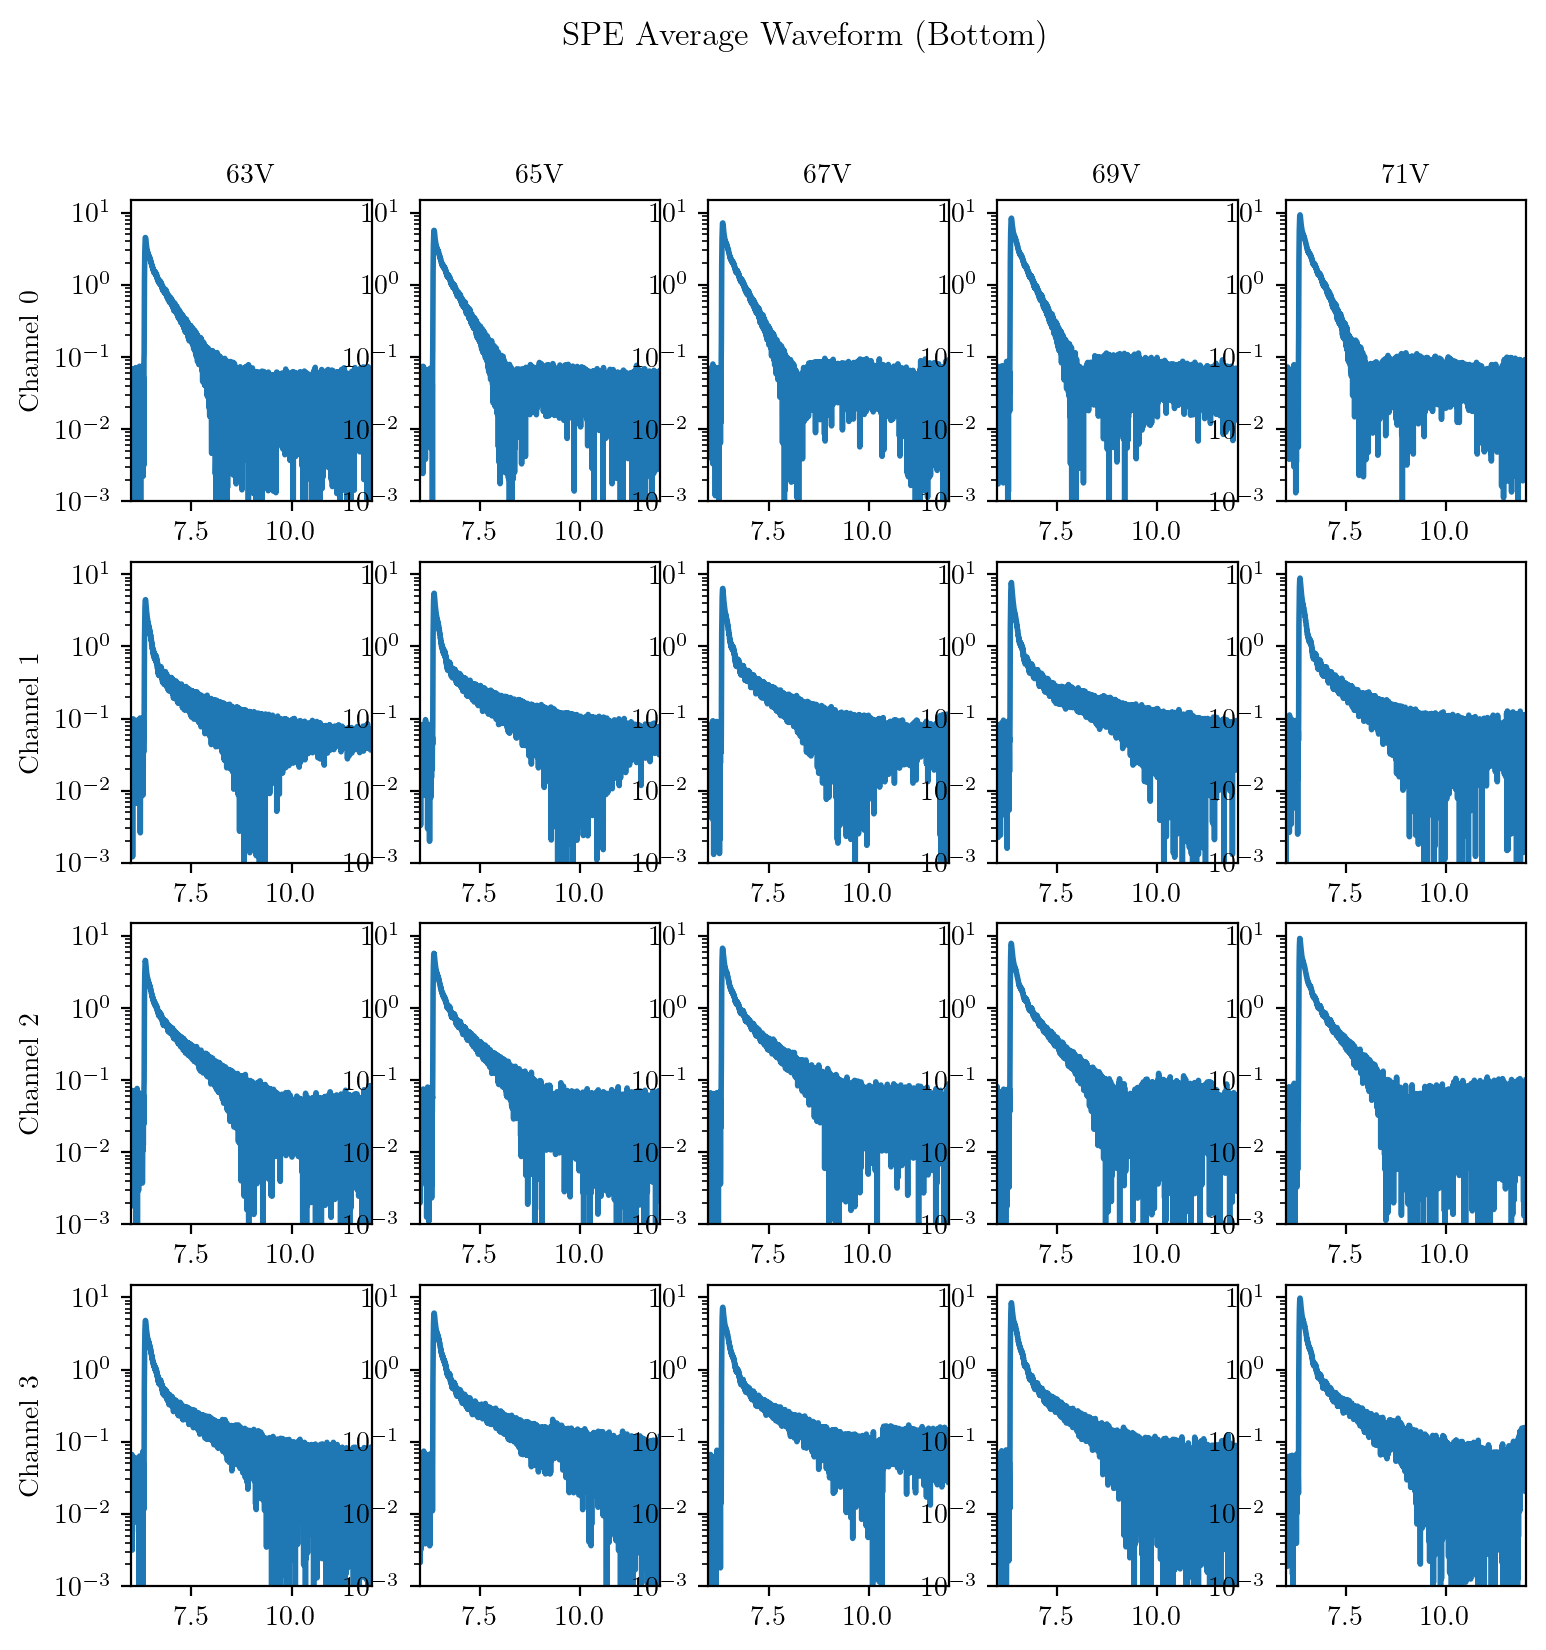

In [48]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for i,v in enumerate(bias):
    file = ROOT.TFile('root/SPE_waveform_1122_{}V_bottom.root'.format(v),'read')
    for ch in range(4):
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        gSPE = file.Get('gSPE_ch{}'.format(ch))
        plt.plot(list(gSPE.GetX()), abs(np.array(list(gSPE.GetY()))))
        # err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        # t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        # t_end = int(data.ch[ch].trigger_position + 5/data.ch[ch].sample_step)
        # popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[5,1,6,0.1,0.005,6.45,6.30], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        # plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        # print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t1={:.3f}+/-{:.3f}us, t2={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5]),popt[6],np.sqrt(pcov[6,6])))
        # data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        # plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.xlim(6,12)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
plt.savefig('plots/sipm/spewf_bot_1122.pdf')

## Take closer look at one channel one voltage

In [ ]:
ch=0
i=2
dset = ds1122top[i].ch[ch]

plt.plot(dset.time, dset.spe_avgwf, label='Data', linewidth=1)
print(np.std(dset.spe_avgwf[:dset.baseline_samples]))
print(dset.baseline_samples*dset.sample_step, np.mean(dset.spe_avgwf[:dset.baseline_samples]), np.median(dset.spe_avgwf[:dset.baseline_samples]))
print(np.mean(dset.spe_avgwf[int(12/dset.sample_step):]), np.median(dset.spe_avgwf[int(12/dset.sample_step):]))
plt.plot(dset.time, dset.get_pulse_shape(dset.time, dset.get_pulse_pars()[0], dset.get_pulse_pars()[1], dset.get_pulse_pars()[2], dset.get_pulse_pars()[3],0.0074,6.327), label='Fit', linewidth=1)
# plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
plt.ylim(-1, 1)
plt.xlim(0,16)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.suptitle('SPE Average Waveform (Top Ch{} {}V)'.format(ch.bias[i]))


NameError: name 'datasets_top' is not defined

# Try FFT-based deconvolution
- $\tilde{f}(\omega)$: average waveform FFT
- $\tilde{g}(\omega)$: start time distribution FFT
- $\tilde{h}(\omega)$: SiPM pulse FFT
$$\tilde{g}(\omega) \propto \frac{\tilde{f}(\omega)}{\tilde{h}(\omega)}$$

In [ ]:
from scipy.fft import fft, ifft
dset = datasets_bot[2].ch[0]
ftilde = fft(dset.spe_avgwf)
a1,tau1,a2,tau2 = dset.get_pulse_pars()
h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
htilde = fft(h(dset.time))

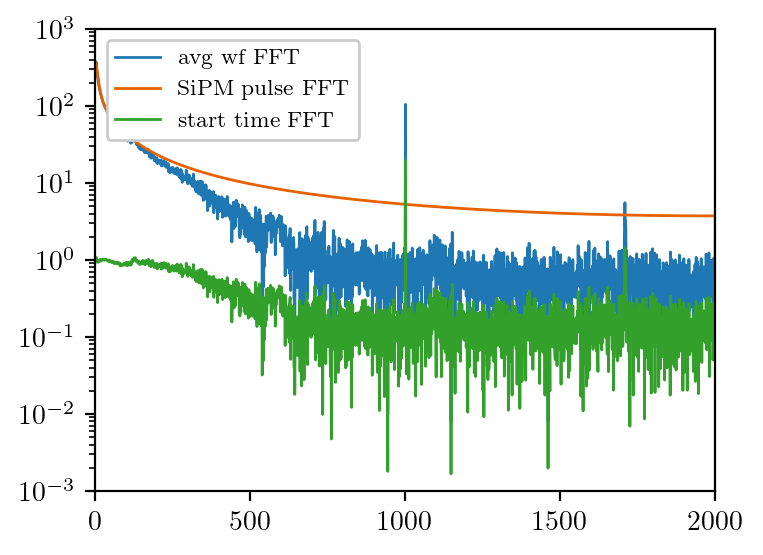

In [ ]:
plt.plot(abs(ftilde), label='avg wf FFT', linewidth=1)
plt.plot(abs(htilde), label='SiPM pulse FFT', linewidth=1)
plt.plot(abs(ftilde/htilde), label='start time FFT', linewidth=1)
plt.legend()
plt.xlim(0,2000)
plt.yscale('log')

/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.9400054783777446


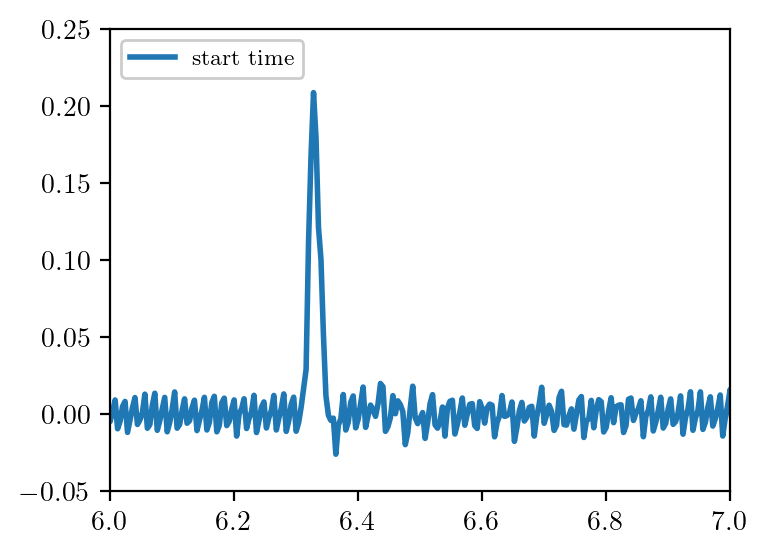

In [ ]:
plt.plot(dset.time, ifft(ftilde/htilde), label='start time')
plt.legend()
plt.xlim(6,7)
print(abs(np.sum((ifft(ftilde/htilde)))))